---

##  1.세계 테러 데이터 분석<a class="anchor" id="chapter1"></a>

Analysis of global terror activies between 1970 to 2017 using data provided by START Consortium

###  1.1 Definition of Terrorism <a class="anchor" id="section_1_1"></a>

The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by a nonstate actor to attain a political, economic, religious, or social goal through fear, coercion, or intimidation.

###  1.2 Limitations on Data <a class="anchor" id="section_1_2"></a>

- removed rows for those that do not provide longitude and latitude infomation
- defaulted Month and Day of those not provided to Jan 1
- defaulted to 0 for those rows that do not provide death and injured data
- where city or nationality infomation was left blank, defaulted to "Unknown"
- 1993 data excluded from the dataset as the 1993 data were lost prior to START's compilation of the GTD.

In [2]:
import requests
import spacy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
topic="terror"
numResults=1000
url ="https://www.google.com/search?q="+topic+"&tbm=nws&hl=en&num="+str(numResults)

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

results = soup.find_all('div', attrs = {'class': 'ZINbbc'})
descriptions = []
for result in results:
    try:
        description = result.find('div', attrs={'class':'s3v9rd'}).get_text()
        if description != '': 
            descriptions.append(description)
    except:
        continue

text = ''.join(descriptions)
sp = spacy.load('en_core_web_sm')
doc = sp(text)

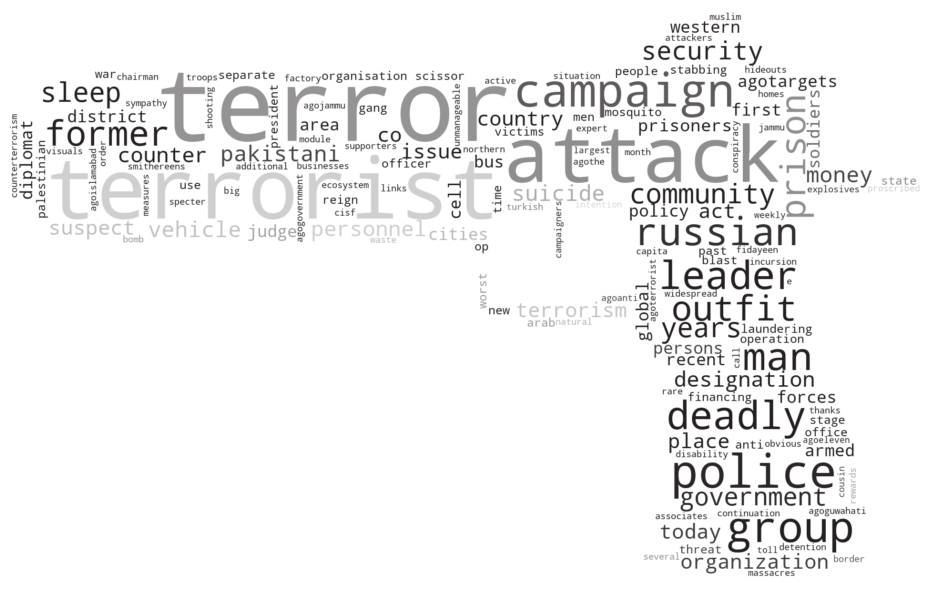

In [3]:
ignore = ['day', 'week', 'year', 'hours', 'days', 'month', 'months', 'weeks']
newText =''
for word in doc:
    if str(word) in ignore:
        continue
    elif word.pos_ in ['ADJ', 'NOUN']:
        newText = " ".join((newText, word.text.lower()))

mask = np.array(Image.open("./wordcloud_image.png"))
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(
    width=800, height=400, 
    stopwords=STOPWORDS, 
    background_color="white", 
    mask=mask, 
    color_func=image_colors,
    max_words=150
    ).generate(newText)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

---

## 2. 데이터 불러오기 <a class="anchor" id="chapter2"></a>

In [3]:
import pandas as pd
import numpy as np

In [4]:
terror_raw = pd.read_csv('./data/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1', usecols=[1, 2, 3, 8, 10, 12, 13, 14, 26, 29, 35, 41, 58, 82, 98, 101])

# 컬럼명 재설정
terror_raw = terror_raw.rename(
    columns={
        'iyear':'year',
        'imonth':'month',
        'iday':'day',
        'country_txt':'country',
        'region_txt':'region',
        'attacktype1_txt':'attack_type',
        'targtype1_txt':'victim',
        'natlty1_txt':'nationality',
        'gname':'group',
        'weaptype1_txt':'weapon',
        'nkill':'death',
        'nwound':'wound'
    }
)

# dropping rows without latitude and longitude data
terror_raw = terror_raw.dropna(subset=['latitude', 'longitude'])

# fillna
terror_raw['death'] = terror_raw['death'].fillna(0).astype(int)
terror_raw['death'] = terror_raw['death'].astype(int)

terror_raw['wound'] = terror_raw['wound'].fillna(0).astype(int)
terror_raw['wound'] = terror_raw['wound'].astype(int)

terror_raw['city'] = terror_raw['city'].fillna('Unknown')
terror_raw['nationality'] = terror_raw['nationality'].fillna('Unknown')

# change data type to int for year, month, date
terror_raw['year'] = terror_raw['year'].astype(int)
terror_raw['month'] = terror_raw['month'].astype(int)
terror_raw['day'] = terror_raw['day'].astype(int)

# convert 0 month and 0 day to default to January 1
terror_raw['month'].replace(0, 1, inplace=True)
terror_raw['day'].replace(0, 1, inplace=True)

# create dateid
terror_raw['dateInt']=terror_raw['year'].astype(str) + terror_raw['month'].astype(str).str.zfill(2)+ terror_raw['day'].astype(str).str.zfill(2)
terror_raw['date'] = pd.to_datetime(terror_raw['dateInt'], format='%Y%m%d')
terror_raw = terror_raw.drop('dateInt', axis=1)

terror_raw.reset_index(drop=True, inplace=True)

In [6]:
terror_raw.head()

,year,month,day,country,region,city,latitude,longitude,success,attack_type,victim,nationality,group,weapon,death,wound,date
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,1,Assassination,Private Citizens & Property,Dominican Republic,MANO-D,Unknown,1,0,1970-07-02
1,1970,1,1,Mexico,North America,Mexico city,19.371887,-99.086624,1,Hostage Taking (Kidnapping),Government (Diplomatic),Belgium,23rd of September Communist League,Unknown,0,0,1970-01-01
2,1970,1,1,Philippines,Southeast Asia,Unknown,15.478598,120.599741,1,Assassination,Journalists & Media,United States,Unknown,Unknown,1,0,1970-01-01
3,1970,1,1,Greece,Western Europe,Athens,37.997490,23.762728,1,Bombing/Explosion,Government (Diplomatic),United States,Unknown,Explosives,0,0,1970-01-01
4,1970,1,1,Japan,East Asia,Fukouka,33.580412,130.396361,1,Facility/Infrastructure Attack,Government (Diplomatic),United States,Unknown,Incendiary,0,0,1970-01-01


In [7]:
# export for tableau purposes
terror_raw.to_csv('./data/terror_raw_tableau_4.csv', sep=',', index=0)

In [18]:
# add columns for analysis
terror_raw['casualties'] = terror_raw['death'] + terror_raw['wound']
terror_raw['count'] = int(1)
terror_raw['fatality_rt'] = terror_raw['death']/terror_raw['casualties']
terror_raw['fatality_rt'] = terror_raw['fatality_rt'].fillna(0).astype(float)

In [19]:
terror_raw.head()

,year,month,day,country,region,city,latitude,longitude,success,attack_type,victim,nationality,group,weapon,death,wound,date,casualties,count,fatality_rt
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,1,Assassination,Private Citizens & Property,Dominican Republic,MANO-D,Unknown,1,0,1970-07-02,1,1,1.0
1,1970,1,1,Mexico,North America,Mexico city,19.371887,-99.086624,1,Hostage Taking (Kidnapping),Government (Diplomatic),Belgium,23rd of September Communist League,Unknown,0,0,1970-01-01,0,1,0.0
2,1970,1,1,Philippines,Southeast Asia,Unknown,15.478598,120.599741,1,Assassination,Journalists & Media,United States,Unknown,Unknown,1,0,1970-01-01,1,1,1.0
3,1970,1,1,Greece,Western Europe,Athens,37.997490,23.762728,1,Bombing/Explosion,Government (Diplomatic),United States,Unknown,Explosives,0,0,1970-01-01,0,1,0.0
4,1970,1,1,Japan,East Asia,Fukouka,33.580412,130.396361,1,Facility/Infrastructure Attack,Government (Diplomatic),United States,Unknown,Incendiary,0,0,1970-01-01,0,1,0.0


In [4]:
# saving as csv for analysis
terror_raw.to_csv('./data/terror_raw_analysis.csv', sep=',')

NameError: name 'terror_raw' is not defined

---

## 3. 연도별 테러 집계 <a class="anchor" id="chapter3"></a>

In [5]:
terror_raw = pd.read_csv('./data/terror_raw_analysis.csv', sep=',', index_col=0)

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import rc

%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'
# sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False})

###  3.1. 1970-2017년 전 세계 테러 건수 <a class="anchor" id="chapter_3_1"></a>

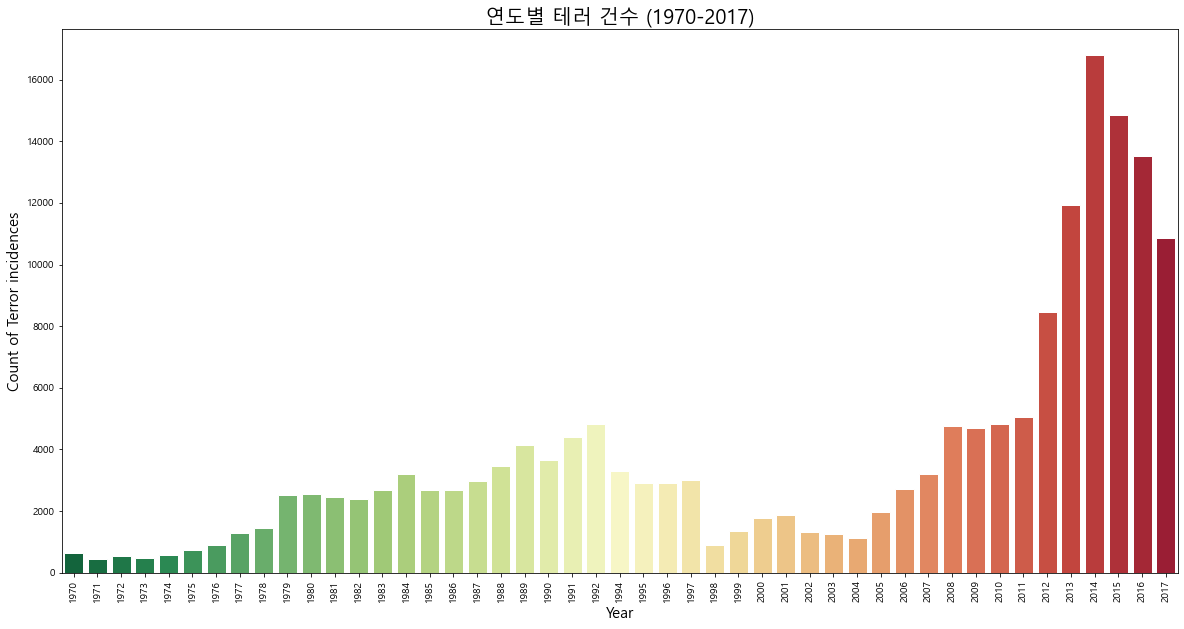

In [7]:
plt.subplots(figsize=(20,10))
sns.set_style("darkgrid")
sns.countplot(x='year', data=terror_raw, palette='RdYlGn_r')
plt.xticks(rotation=90)
plt.title('연도별 테러 건수 (1970-2017)', fontsize=20)
plt.ylabel('Count of Terror incidences', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.show()

- 1988년부터 1992년까지의 상승세
- 1993년 데이터 누락으로 인해 1992 - 1994년에 급격히 하락한듯이 보인다
- 1998년 또한 급격히 하락하는듯이 보이는데, START의 코드북에 의하면 1998년 데이터 수집에 변화가 있었다고 한다. 또한 그 시기에 세계적 경제 불황으로 인한 정보 부족이 있었을 수도 있다 생각만 해본다.
- 1998년부터 차차 상승세가 다시 보이고, 2001년에는 9/11 테러가 있었다.
- 2003년부터 이라크 전쟁이 시작 되었다. 따라서 2003년부터 테러의 수가 급격하게 늘기 시작한다.
- 2011년에 미군이 이라크에서 철수하였지만, 2012년부터 다시 한번 역대 최고의 성장세를 보여주기 시작한다.
- 2012년의 성장세는 실제로 테러 수의 성장세도 있었겠지만, START에 의하면 데이터 수집 방식의 변화로 더 많은 데이터를 읽고 기록이 되었다 한다.
- 그리고 마지막으로 2014년을 기점으로 다시 하락세를 보이고 있다.

In [24]:
terror_by_region = terror_raw.groupby(['year', 'region'])['count'].sum()
terror_by_region = terror_by_region.reset_index()

###  3.2. 1970-2017년 지역별 테러 건수 <a class="anchor" id="chapter_3_2"></a>

In [25]:
fig = px.line(
    terror_by_region, x='year', y='count', color='region', markers=True,
    title = '지역 & 연도별 테러 (1970-2017)',
    width=1300, height = 600,
    labels={'region':'지역', 'year':'연도', 'count':'테러 발생 수'},
    template="plotly_white"
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.add_shape(
    type = "line", line_color = "salmon", line_width = 3, opacity = 1, line_dash = "dot", x0=2014, x1=2014, y0=0, y1=7300
)

fig.add_annotation(
    text='최다 발생 연도(2014)', x=2014, y= 7300, arrowhead=1, showarrow=True
)

fig.show()

**South America**
- 1982년부터 증가율이 보이기 시작하며 1984년부터 1992년까지 꾸준히 가장 높은 테러율을 보여주었다.
- 하지만 1992년부터는 급격히 줄어들기 시작했다.
- 어떤 이유로 이 구간에 급격히 변동하는지를 알아보기 위해 South America 지역의 1980-1995 데이터를 집중적으로 살펴보았다.
- 그 시기에 발생한 사건으로 예상하여 보면 페루에서 Shining Path, 1984년 칠레, 또한 콜롬비아가 있다.

###  3.3. 1970-2017년 중동&북아프리카 지역 테러 건수 <a class="anchor" id="chapter_3_3"></a>

In [10]:
# 중동 & 아프리카 지역 데이터 처리

terror_by_country = terror_raw.groupby(['year', 'region', 'country'])['count'].sum()
terror_by_country = terror_by_country.reset_index()

In [9]:
# max 좌표 찍기 위한 함수

def getMaxMarker(region, value):
    ymax = max(terror_by_country[terror_by_country['region']==region][value])
    xmax = terror_by_country.loc[terror_by_country[value]==ymax,'year']
    maxcountry = ''.join(terror_by_country.loc[terror_by_country[value]==ymax,'country'].tolist())

    return ymax, xmax, maxcountry

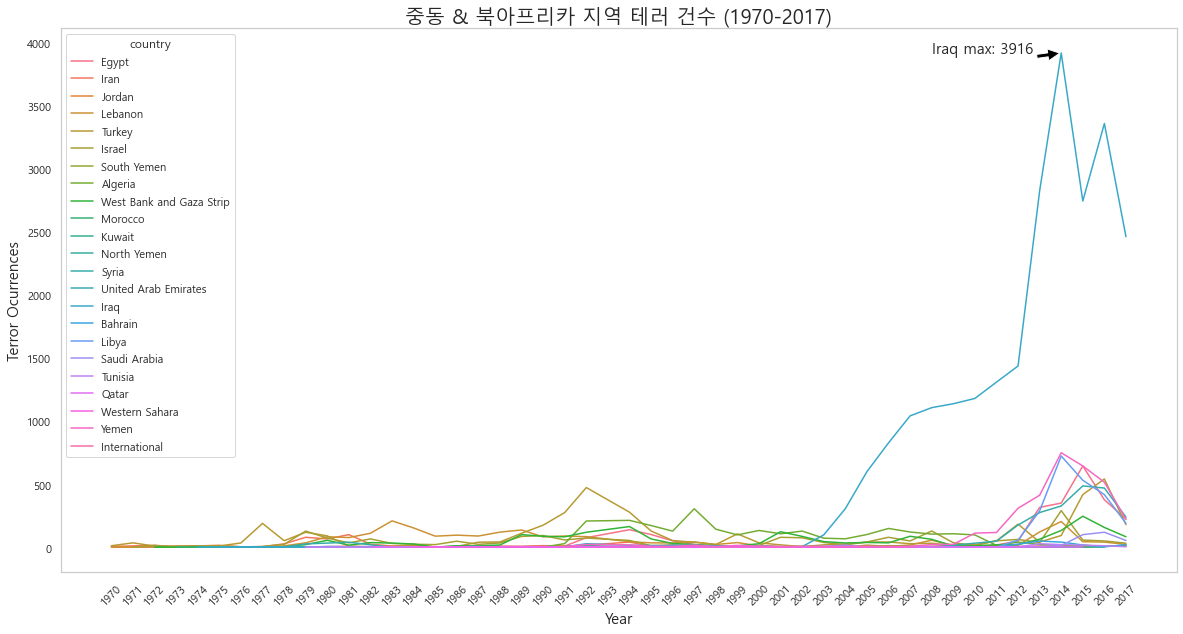

In [35]:
ymax, xmax, maxcountry = getMaxMarker("Middle East & North Africa", "count")

plt.figure(figsize=(20,10))
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style="white")
sns.lineplot(data=terror_by_country[terror_by_country['region']=='Middle East & North Africa'], x='year', y='count', hue='country')
plt.xticks(ticks=np.arange(1970, 2018, 1), rotation=45)
plt.title('중동 & 북아프리카 지역 테러 건수 (1970-2017)', fontsize=20)
plt.ylabel('Terror Ocurrences', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.annotate(text=maxcountry +' max: '+ str(ymax), xy=(xmax, ymax), xytext=(xmax-6, ymax), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.grid(False)
plt.show()

In [12]:
years = np.arange(1970, 2018, 1, dtype=int)

**Middel East & North Africa**
* 2012년 정도부터 2016년까지 큰 상승폭을 보여준다.
* 2014년에는 역대 최다 테러 발생 수를 기록했다. 그 중 가장 큰 비율은 이라크에서 왔다.
* 이라크 외에도 리비아, 예멘, 시리아 모두 2012년부터 상승폭을 보여주었다.
* 이라크만 떼어놓고 보면 2003년 이라크 전쟁부터 시작으로 큰 상승폭을 보여주었다. 하지만 제일 큰 상승을 보였던 시기는 이라크 전쟁 후, 미국군이 이라크를 떠난 시기인 2011/2012년부터다.
* 그 이유로는 2011부터 활동을 재개한 ISIS로 보인다. 같은 시기에 예멘, 리비아, 시리아, 터키 모두 영향을 받았다.

###  3.4. 1970-2017년 남아시아 지역 테러 건수 <a class="anchor" id="chapter_3_4"></a>

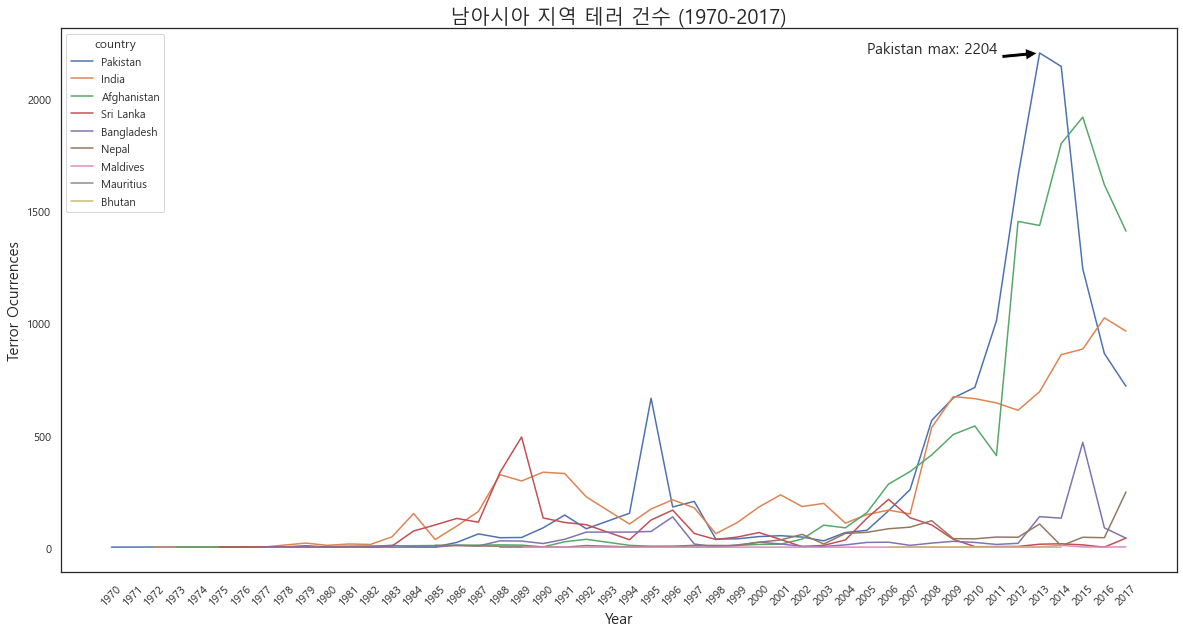

In [22]:
ymax, xmax, maxcountry = getMaxMarker("South Asia", "count")

plt.figure(figsize=(20,10))
sns.lineplot(data=terror_by_country[terror_by_country['region']=='South Asia'], x='year', y='count', hue='country')
plt.xticks(years, rotation=45)
plt.title('남아시아 지역 테러 건수 (1970-2017)', fontsize=20)
plt.ylabel('Terror Ocurrences', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.annotate(text=maxcountry +' max: '+ str(ymax), xy=(xmax, ymax), xytext=(xmax-8, ymax), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=15)
plt.style.context('white_background')
plt.grid(False)
plt.show()

**South Asia**
- 중동 지역에서 보여지는 형상과 비슷하게 남아시아 지역, 특히 파키스탄과 아프가니스탄에서도 2011/2012년을 기점으로 큰 상승폭을 보여주고 있다

---

## 4. 테러 발생 수 상위 10개국 <a class="anchor" id="chapter4"></a>

In [24]:
top10_df = (terror_raw.groupby(['country'])['count', 'wound', 'death'].sum()).reset_index()
top10_df = top10_df.sort_values(['count'], ascending=False)[:10].reset_index(drop=True)

C:\Users\hsada\AppData\Local\Temp/ipykernel_2988/3686964967.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top10_df = (terror_raw.groupby(['country'])['count', 'wound', 'death'].sum()).reset_index()


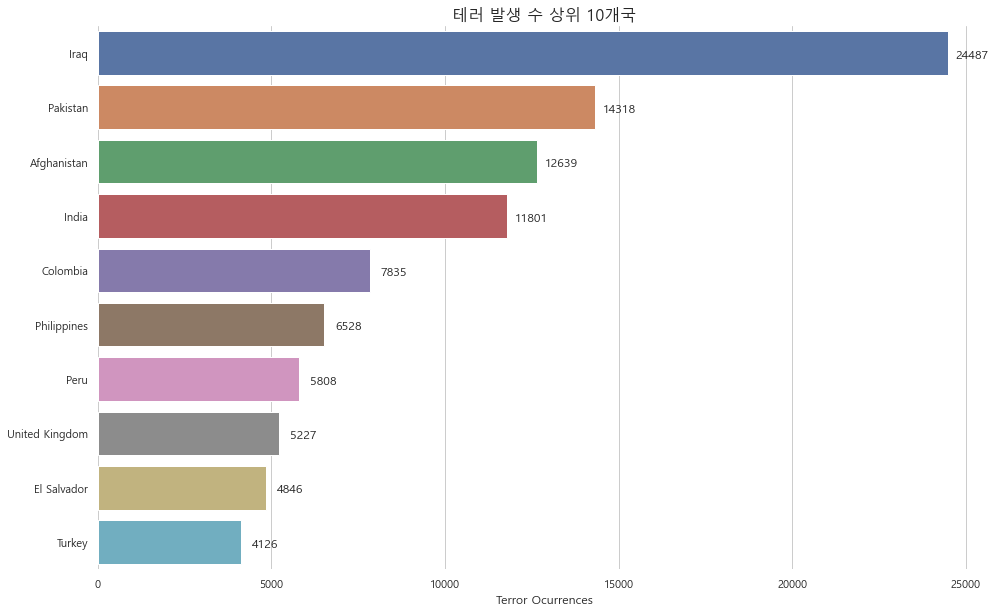

In [33]:
plt.figure(figsize=(16,10))
sns.set(font="Malgun Gothic", rc={"axes.unicode_minus":False}, style="white")
sns.set_color_codes("pastel")
plots = sns.barplot(data = top10_df, x='count', y='country')
for bar in plots.patches:
    width = bar.get_width()
    plt.text(700+width, bar.get_y()+0.55*bar.get_height(), '{:.0f}'.format(width), ha='center', va='center', size=12)
plt.title('테러 발생 수 상위 10개국', fontsize=16)
plt.xlabel('Terror Ocurrences', fontsize=12)
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()

* 이라크가 가장 높은 수를 보이고, 전체적으로 발생 수가 많을수록 사상자 수도 높게 나왔다
* 또한 이라크, 파키스탄, 아프가니스탄 모두 이전에 지역별 분석에서 2011년부터 많은 테러 건수를 기록한 나라로 보였던 나라들이다.

In [23]:
fig = px.choropleth(top10_df, locations='country', locationmode='country names', color='count', color_continuous_scale=px.colors.sequential.Plasma, width=1300, height = 800)
fig.show()

- 필리핀과 영국을 제외하고는 대체로 탑10의 국가는 서로 인접한 위치에 있는 것으로 파악된다

---

## 5. Top10 국가 사상자 비교 분석 <a class="anchor" id="chapter5"></a>

In [24]:
top10_tidy = top10_df.melt(id_vars='country').rename(columns=str.title)

### 5.1. Top10 국가 사상자 수 비교 <a class="anchor" id="chapter_5_1"></a>

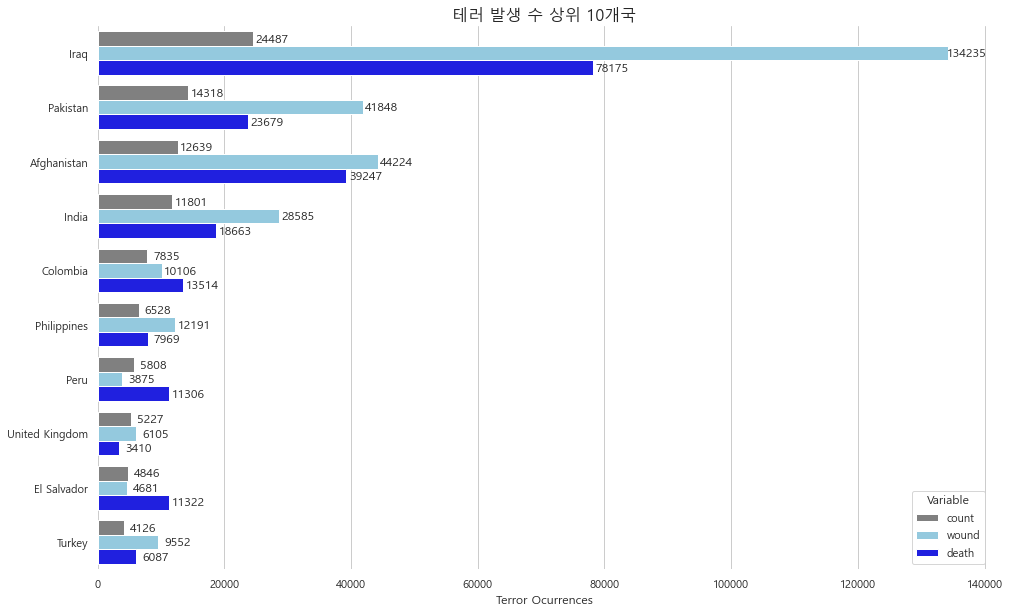

In [25]:
plt.figure(figsize=(16,10))

sns.set_color_codes("bright")
plots = sns.barplot(data = top10_tidy, x='Value', y='Country', hue='Variable', palette=['grey', 'skyblue', 'blue'])
for bar in plots.patches:
    width = bar.get_width()
    plt.text(3000+width, bar.get_y()+0.55*bar.get_height(), '{:.0f}'.format(width), ha='center', va='center', size=12)
plt.title('테러 발생 수 상위 10개국', fontsize=16)
plt.xlabel('Terror Ocurrences', fontsize=12)
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()

- 절대적인 수치를 비교하여 보았을 때, 이라크, 파키스탄, 아프가니스탄 탑3 테러 발생 수 국가가 사상자 수 또한 제일 많은 것으로 보인다.

더 효과적인 비교를 위하여 각 나라의 사망자와 부상자를 테러 발생 수의 백분율로 나타내 보았다

### 5.2. Top10 국가 사상자 백분율 비교 <a class="anchor" id="chapter_5_2"></a>

In [26]:
# 각 국가별 사망자와 부상자를 건수 대비 비율로 더 직관적이게 관찰

top10_percent = top10_df.copy()
top10_percent['wound'] = round((top10_percent['wound']/top10_percent['count']), 2)
top10_percent['death'] = round((top10_percent['death']/top10_percent['count']), 2)
top10_percent['count'] = 1

In [27]:
# Axes[0] Barplot purposes
top10_percent_try = top10_percent.copy()
top10_percent_try = top10_percent_try.reset_index()
top10_percent_try = top10_percent_try.sort_values(by='index', ascending=False)
top10_percent_try = top10_percent_try.drop('index', axis=1)
top10_percent_try_tidy = top10_percent_try.melt(id_vars='country').rename(columns=str.title)

In [28]:
# Axes[1] Barplot purposes
top10_percent_try_pivot = top10_percent_try.set_index('country', drop=True)

In [29]:
# Axes[1] Barplot text location purposes
top10_modified = top10_percent_try.copy()
top10_modified['wound'] = top10_modified['wound'] + 1
top10_modified['death'] = top10_modified['wound'] + top10_modified['death']
top10_modified_tidy = top10_modified.melt(id_vars='country').rename(columns=str.title)
width_lst = top10_modified_tidy['Value'].tolist()
width_txt_lst = top10_percent_try_tidy['Value'].tolist()

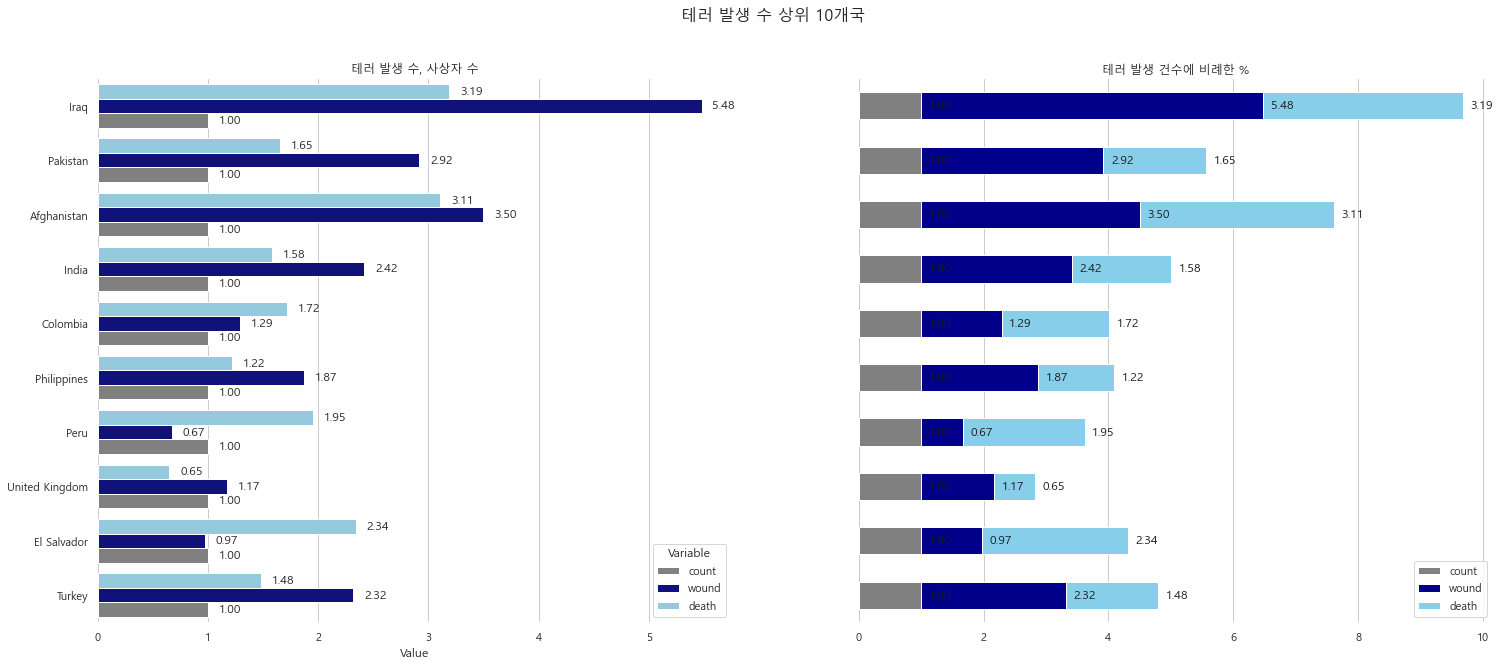

In [30]:
fig, ax = plt.subplots(1,2, figsize=(25,10), sharey=True)
plt.suptitle('테러 발생 수 상위 10개국', fontsize=16)


sns.set_color_codes("pastel")
plot1 = sns.barplot(data = top10_percent_try_tidy, x='Value', y='Country', hue='Variable', ax=ax[0], palette=['grey', 'darkblue', 'skyblue'])
for bar in plot1.patches:
    width = bar.get_width()
    ax[0].text(0.2+width, bar.get_y()+0.5*bar.get_height(), '{:.2f}'.format(width), ha='center', va='center', size=12)
ax[0].set_title('테러 발생 수, 사상자 수', fontsize=12)
ax[0].grid(axis='x')
ax[0].set_ylabel("")
sns.despine(left=True, bottom=True)


plots = top10_percent_try_pivot.plot(kind='barh', stacked=True, color=['grey', 'darkblue', 'skyblue'], ax=ax[1])
n=0
for bar in plots.patches:
    width = width_lst[n]
    ax[1].text(0.3+width, bar.get_y()+0.5*bar.get_height(), '{:.2f}'.format(width_txt_lst[n]), ha='center', va='center', size=12, color='k')
    n+=1

ax[1].legend()
ax[1].set_title('테러 발생 건수에 비례한 %', fontsize = 12)
ax[1].grid(axis='x')
ax[1].set_ylabel("")

plt.show()

- 오른쪽 표를 보면 테러 건수 대비 사상자의 패턴이 잘 보인다. 대체로 테러 수에 비례하게 사상자의 수가 늘어나는 듯 보이지만, 몇가지 예외 사항이 보인다.
- 아프가니스탄, 엘살바도르, 터키의 경우 테러 건수에 비해 많은 사상자가 나왔다. 인구 밀집도와 연관 되어 있을 수 있으니, 사상자의 큰 비율이 민간인이었는지 확인해 볼 필요가 있어 보인다.
- 반면에 영국은 테러 건수에 비해 사상자의 수가 비교적 적은 편이다. Top10 국가에서는 이례적으로 사망자 수가 테러 건수보다 적기도 하다. 유럽 선진국 특성상 테러 대비가 더 철저했을 수 있다는 가정하에, 테러의 성공율을 확인해 볼 필요가 있어 보인다.
- 또한 콜롬비아, 페루, 엘살바도르 국가들은 사망자의 수가 부상자의 수보다 더 높게 나왔다. 테러의 공격 형태가 사망자의 수를 더 높게 했을 확율이 있는지 확인해 볼 필요가 있어 보인다.

### 5.3. Top10 국가 테러 성공율 비교 <a class="anchor" id="chapter_5_3"></a>

In [31]:
countries_df = terror_raw.groupby('country').agg({
                                    'success':'mean',
                                    'count':'sum',
                                    'wound':'sum',
                                    'death':'sum'
})
countries_top10_df = countries_df.sort_values(by='count', ascending=False)[:10]
countries_top10_df['success'] = round(countries_top10_df['success'] * 100, 1)
countries_top10_df

,success,count,wound,death
country,,,,
Iraq,88.7,24487,134235,78175
Pakistan,87.7,14318,41848,23679
Afghanistan,87.5,12639,44224,39247
India,85.8,11801,28585,18663
Colombia,92.6,7835,10106,13514
Philippines,85.9,6528,12191,7969
Peru,94.2,5808,3875,11306
United Kingdom,80.4,5227,6105,3410
El Salvador,98.1,4846,4681,11322


In [32]:
# top10 평균 테러 성공율
top10_success = countries_top10_df['success'].mean()

# weighted average 성공율
top10_weighted = np.average(countries_top10_df['success'], weights=countries_top10_df['count'])

top10_success, top10_weighted

(89.17999999999999, 88.61558571940787)

- 위의 바차트를 보며 추측했듯이 영국의 테러 성공율은 탑텐 국가의 평균 성공율인 89%보다 낮은 80%로 나온다.
- 상대적으로 낮은 성공율로 인하여 사상자수가 적었다고 추론해 볼 수 있다. 하지만 테러의 공격 형태 또한 영향을 줄 수 있기에, 공격 형태별 사상자도 확인해 볼 필요가 있어보인다.

---

## 6. 지역별 테러 공격 형태 비교 분석 <a class="anchor" id="chapter6"></a>

In [33]:
attack_df = (terror_raw.groupby(['region', 'attack_type'])['count', 'wound', 'death'].sum()).reset_index()

attack_df['wound_pct'] = attack_df['wound']/attack_df['count']
attack_df['death_pct'] = attack_df['death']/attack_df['count']
attack_df['count_pct'] = 1
attack_df.head()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/918849479.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,region,attack_type,count,wound,death,wound_pct,death_pct,count_pct
0,Australasia & Oceania,Armed Assault,51,87,78,1.705882,1.529412,1
1,Australasia & Oceania,Assassination,30,8,33,0.266667,1.100000,1
2,Australasia & Oceania,Bombing/Explosion,75,77,9,1.026667,0.120000,1
3,Australasia & Oceania,Facility/Infrastructure Attack,71,13,0,0.183099,0.000000,1
4,Australasia & Oceania,Hijacking,3,0,0,0.000000,0.000000,1


In [34]:
attack_df['region'].unique()

array(['Australasia & Oceania', 'Central America & Caribbean',
       'Central Asia', 'East Asia', 'Eastern Europe',
       'Middle East & North Africa', 'North America', 'South America',
       'South Asia', 'Southeast Asia', 'Sub-Saharan Africa',
       'Western Europe'], dtype=object)

In [35]:
select_regions = ['Middle East & North Africa', 'South Asia', 'South America', 'Western Europe', 'Southeast Asia', 'Eastern Europe', 'North America', 'East Asia']

### 6.1. 지역별 공격 형태 분석 <a class="anchor" id="chapter_6_1"></a>

In [36]:
# treemap

fig = px.treemap(attack_df[attack_df['region'].isin(select_regions)], path=[px.Constant("World"), 'region', 'attack_type'], values='count',
                color='count',
                color_continuous_scale='Blues'
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



- 대체로 폭발물 -> 무력 공격 -> 암살 순으로 빈번하게 일어 나는 패턴을 보여주고 있다.
- 예외로는 서유럽 지역이다. 서유럽에서는 폭발물 다음으로 암삼, 시설물 공격이 가장 빈번하게 일어났다. 

### 6.2. 성공한 테러 데이터로만 지역별 공격 분석 <a class="anchor" id="chapter_6_2"></a>

In [37]:
terror_success = terror_raw[terror_raw['success']==1]

atk_success = (terror_success.groupby(['region', 'attack_type'])['count', 'wound', 'death', 'casualties'].sum()).reset_index()

atk_success['wound_pct'] = atk_success['wound']/atk_success['count']
atk_success['death_pct'] = atk_success['death']/atk_success['count']
atk_success['count_pct'] = 1
atk_success['fatality_rt'] = atk_success['death']/atk_success['casualties']
atk_success['fatality_rt'] = atk_success['fatality_rt'].fillna(0).astype(float)
atk_success['casualties_pct'] = atk_success['casualties']/atk_success['count']
atk_success.head()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/4287495474.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,region,attack_type,count,wound,death,casualties,wound_pct,death_pct,count_pct,fatality_rt,casualties_pct
0,Australasia & Oceania,Armed Assault,48,86,77,163,1.791667,1.604167,1,0.472393,3.395833
1,Australasia & Oceania,Assassination,21,3,31,34,0.142857,1.476190,1,0.911765,1.619048
2,Australasia & Oceania,Bombing/Explosion,65,77,9,86,1.184615,0.138462,1,0.104651,1.323077
3,Australasia & Oceania,Facility/Infrastructure Attack,68,13,0,13,0.191176,0.000000,1,0.000000,0.191176
4,Australasia & Oceania,Hijacking,3,0,0,0,0.000000,0.000000,1,0.000000,0.000000


In [38]:
# treemap

fig = px.treemap(atk_success[atk_success['region'].isin(select_regions)], path=[px.Constant("World"), 'region', 'attack_type'], values='count',
                color='count',
                color_continuous_scale='Blues'
)
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\hsada\anaconda3\envs\ds_study\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [39]:
atk_success_selected = atk_success[atk_success['region'].isin(select_regions)]
atk_success_casualties = atk_success_selected.pivot(index='region', columns='attack_type')['casualties_pct']
atk_success_fatal = atk_success_selected.pivot(index='region', columns='attack_type')['fatality_rt']

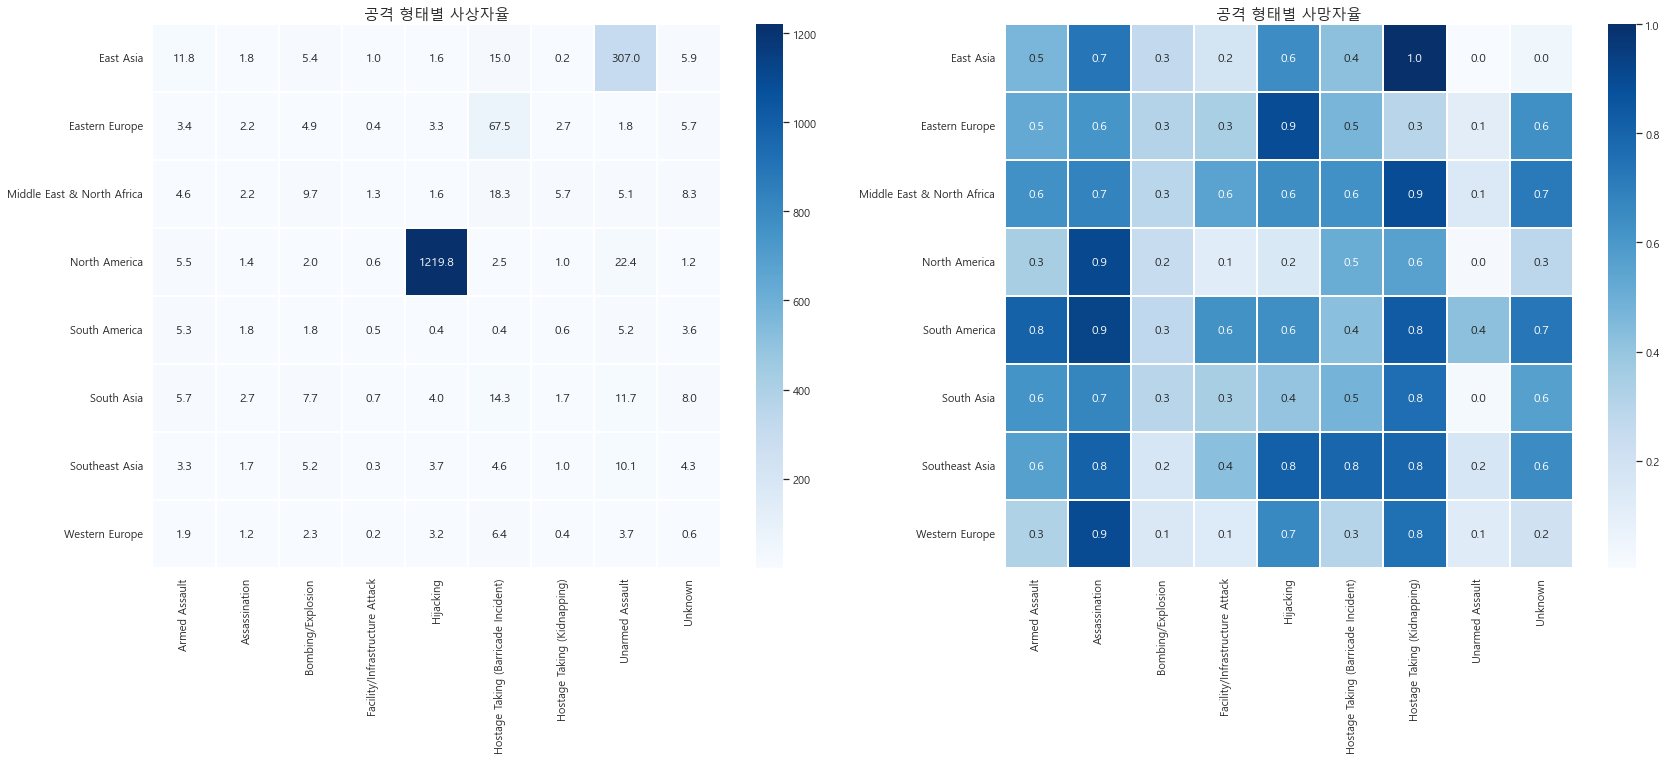

In [40]:
# heatmap

fig, ax = plt.subplots(1, 2, figsize=(28,10))

sns.heatmap(atk_success_casualties,
            annot = True,
            linewidths= 0.3,
            linecolor='white',
            fmt='.1f',
            cmap='Blues',
            ax=ax[0])

ax[0].set_title('공격 형태별 사상자율', fontsize=15)
ax[0].set_xlabel("")
ax[0].set_ylabel("")

sns.heatmap(atk_success_fatal,
            annot = True,
            linewidths= 0.3,
            linecolor='white',
            fmt='.1f',
            cmap='Blues',
            ax=ax[1])

ax[1].set_title('공격 형태별 사망자율', fontsize=15)
ax[1].set_xlabel("")
ax[1].set_ylabel("")

plt.show()

* 가장 빈번하게 일어나는 폭발물로 인한 테러는 대체로 70% 부상자와 30% 사망자로 다른 형태의 공격에 비해 사망자율은 낮은 편이지만 사상자 수는 높은 편이다. 
* 암살이라는 공격 형태 특성상 사상자는 적지만 가장 높은 사망자율을 보여준다.
* 무력 공격의 테러 형태는 사상자율도 높지만, 사망자율도 높게 보인다.
* 왼쪽 사상자율 비교 그래프에서 미국 하이재킹 사건의 사상자율이 압도적으로 높아 비교 분석이 어려워 보인다. 하이재킹 사건은 9/11 테러로 추측된다.
* 또한 동아시아 지역의 unarmed assault로 인한 테러가 타 지역에 비해 높아 보이므로 좀 더 알아볼 필요가 있어 보인다.

In [41]:
# 가장 영향 큰 아웃라이어 제외시키기
idx_911 = terror_success.index[(terror_success['date']=='2001-09-11') & (terror_success['region'] == 'North America')].tolist()

removed_911 = terror_success.drop(idx_911, axis=0)

In [42]:
idx_ea = removed_911[(removed_911['attack_type']=='Unarmed Assault') & (removed_911['region'] == 'East Asia')]
idx_ea = idx_ea[['casualties']].idxmax()

removed_outliers = removed_911.drop(idx_ea, axis=0)

In [43]:
removed_outliers_heatmap = (removed_outliers.groupby(['region', 'attack_type'])['count', 'wound', 'death', 'casualties'].sum()).reset_index()
removed_outliers_heatmap['casualties_pct'] = removed_outliers_heatmap['casualties']/removed_outliers_heatmap['count']
removed_outliers_heatmap['fatality_rt'] = removed_outliers_heatmap['death']/removed_outliers_heatmap['casualties']
removed_outliers_heatmap['fatality_rt'] = removed_outliers_heatmap['fatality_rt'].fillna(0).astype(float)

removed_outliers_heatmap = removed_outliers_heatmap[removed_outliers_heatmap['region'].isin(select_regions)]
removed_outliers_heatmap_casualties = removed_outliers_heatmap.pivot(index='region', columns='attack_type')['casualties_pct']
removed_outliers_heatmap_fatal = removed_outliers_heatmap.pivot(index='region', columns='attack_type')['fatality_rt']

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2375659334.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



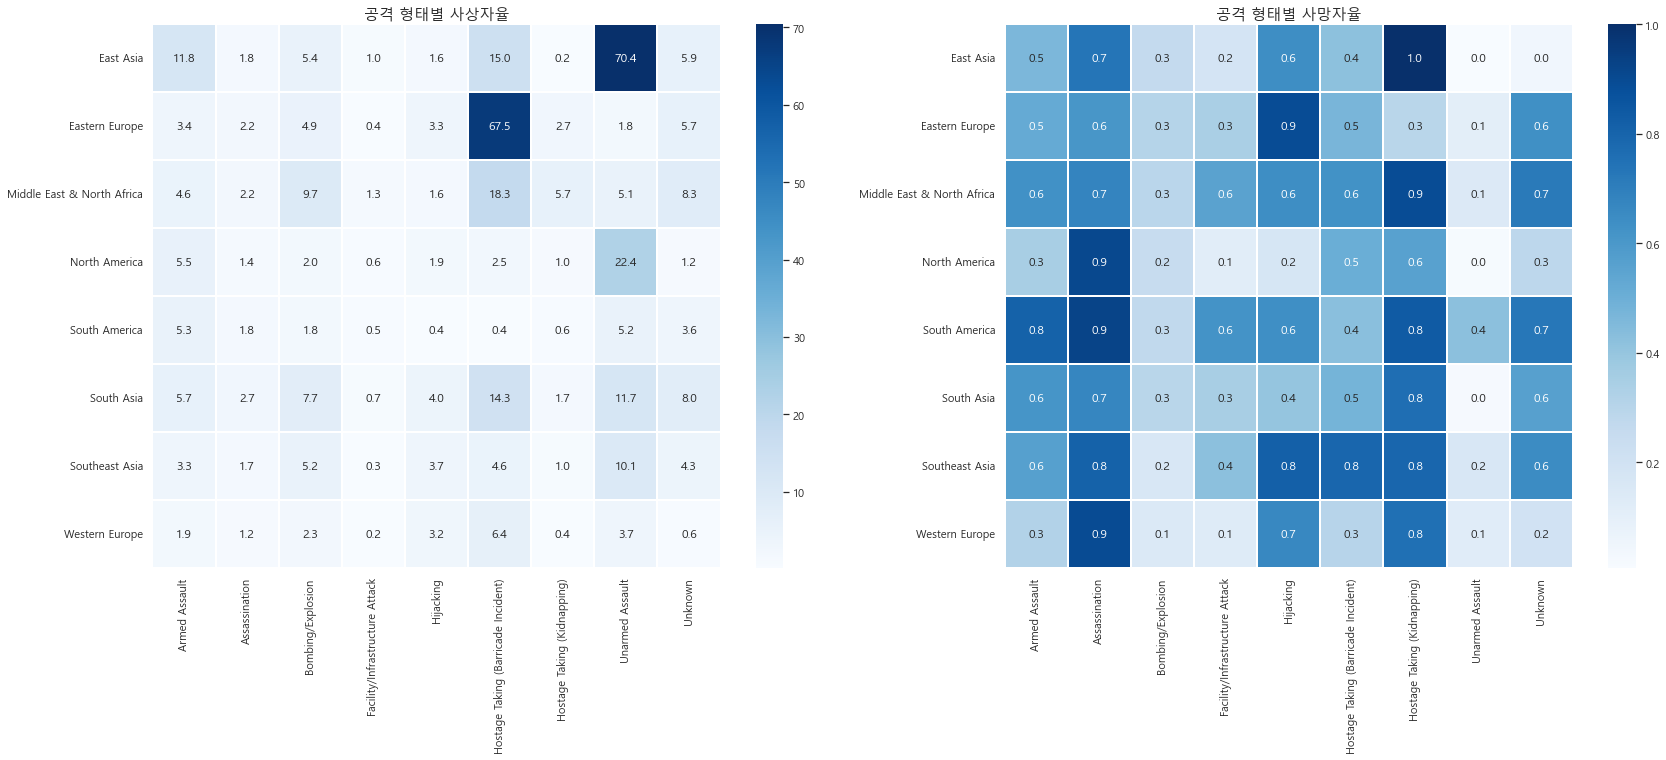

In [44]:
# heatmap without 911 and 1995 Tokyo subway attack 

fig, ax = plt.subplots(1, 2, figsize=(28,10))

sns.heatmap(removed_outliers_heatmap_casualties,
            annot = True,
            linewidths= 0.3,
            linecolor='white',
            fmt='.1f',
            cmap='Blues',
            ax=ax[0])

ax[0].set_title('공격 형태별 사상자율', fontsize=15)
ax[0].set_xlabel("")
ax[0].set_ylabel("")

sns.heatmap(removed_outliers_heatmap_fatal,
            annot = True,
            linewidths= 0.3,
            linecolor='white',
            fmt='.1f',
            cmap='Blues',
            ax=ax[1])

ax[1].set_title('공격 형태별 사망자율', fontsize=15)
ax[1].set_xlabel("")
ax[1].set_ylabel("")

plt.show()

### 6.3. 지역별 테러 공격 특징 분석 <a class="anchor" id="chapter_6_3"></a>

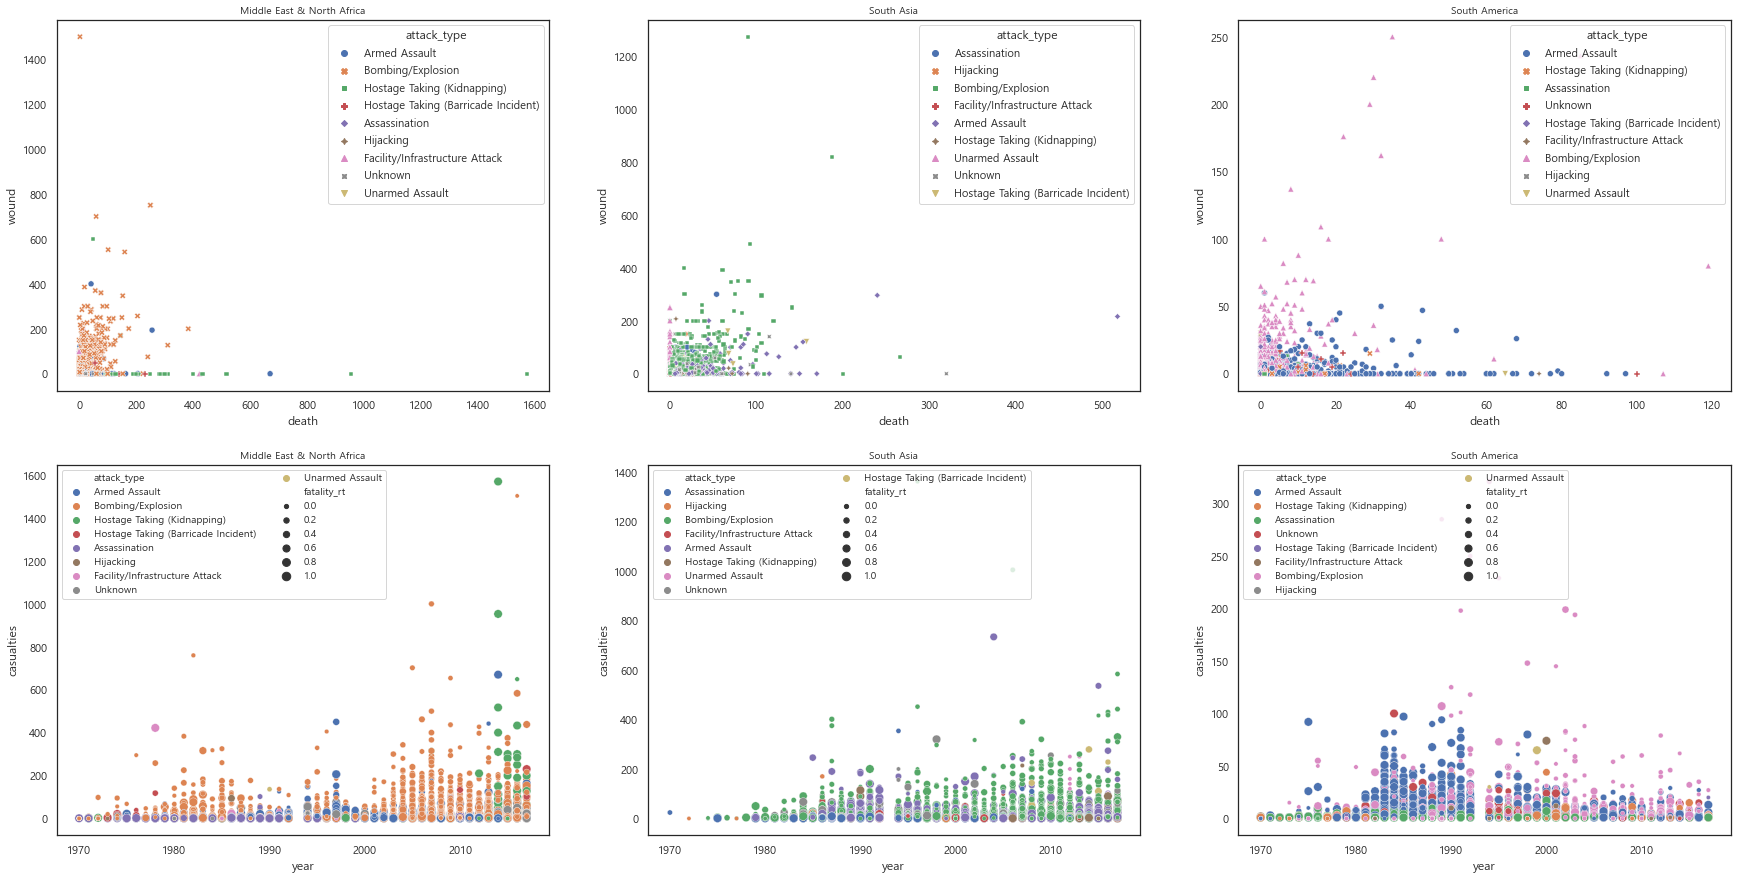

In [45]:
fig, ax = plt.subplots(2,3, figsize=(30,15))

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='Middle East & North Africa'], ax=ax[0][0])
ax[0][0].set_title("Middle East & North Africa", fontsize=10)

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='South Asia'], ax=ax[0][1])
ax[0][1].set_title("South Asia", fontsize=10)

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='South America'], ax=ax[0][2])
ax[0][2].set_title("South America", fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='Middle East & North Africa'], ax=ax[1][0])
ax[1][0].set_title("Middle East & North Africa", fontsize=10)
ax[1][0].legend(loc="upper left", ncol=2, fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='South Asia'], ax=ax[1][1])
ax[1][1].set_title("South Asia", fontsize=10)
ax[1][1].legend(loc="upper left", ncol=2, fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='South America'], ax=ax[1][2])
ax[1][2].set_title("South America", fontsize=10)
ax[1][2].legend(loc="upper left", ncol=2, fontsize=10)

plt.show()

- 위의 3개 지역에서는 앞서서 분석한바와 같이 폭발물의 건수가 제일 많은 형상을 보여준다
- 중동지역과 남아프리카의 경우에는 폭발물 사건의 사망자율은 남아시아 지역의 폭발물 사건보다는 적은 편으로 보인다

**중동 지역**
- 한 건의 폭발물로인한 outlier가 보인다. 이 사건은 2016년 3월 이라크 북부 키르쿠크 인근의 작은 마을 타자에서 터진 화학 무기 공격으로 보인다. 
- 그리고 가장 많은 사상자를 낸 사건으로는 2014년 6월 이라크 티크리트시의 스파이커 캠프에서 일어난 대량학살로 보여진다.
- 또 다른 outlier로는 폭발물로 953명의 사망자를 기록한 2014년 8월 신자르 대량 학살 사건으로 보인다.
- 대체로 큰 사상자를 낸 사건은 2010년대로 몰려 있어 보이며, 2010년대에 인질극으로 인한 테러 형태가 가장 많은 사상율을 보여주고 있다.

**남아시아 지역**
- 대체로 폭발물로 인한 사건이 많은 사상자로 이어지는 현상이 보인다
- 또한 2000년대 중/후반부터 테러의 수도 증가하고, 사상자도 더 높게 집게되는 현상이 보인다.
- 2건의 무력 공격이 보다 많은 사망자를 내는 outlier로 보여진다. 각각 2000년대 중반, 2010년대 중반 사건으로
- 2000년대 중반의 사건은 2004년 3월에 일어난 마오이스트 집단에 의한 반정부 테러이다. 2003년부터 이어저온 네팔 내부의 충돌로, 그 시기에 네팔의 테러 건수가 상승했었다.
- 한 건의 암살 사건이 위에서 봤던 평균적인 암살의 사상자율과 다른 모습을 보인다. 타밀 타이거로 추정되는 집단에서 1994년 10월 24일 스리랑카의 대통령 후보 암살 의도로 자살폭탄 테러가 일어났다. 테러 방식 자체는 폭발물이었기에 암살 분류에서 평균보다 많은 사상자가 나온 것으로 보인다.

**남아메리카 지역**
- 폭발물 사건과 무력 공격 사건이 압도적으로 많아 보이며, 무력 공격은 대체로 보다 많은 사망자를 내는 사건으로 보인다
- 중동이나 남아시아 지역에 비해 무력 공격으로 인한 사망자가 많아 보이고, 사망자율 또한 다른 지역에 비해 많이 높아 보인다.
- 두 건의 폭발물 사건이 위에서 보았던 평균적인 폭발물 사건의 사망자율과는 다르게 부상자보다 사망자가 더 많은 현상을 보이고 있다.

In [46]:
select_regions

['Middle East & North Africa',
 'South Asia',
 'South America',
 'Western Europe',
 'Southeast Asia',
 'Eastern Europe',
 'North America',
 'East Asia']

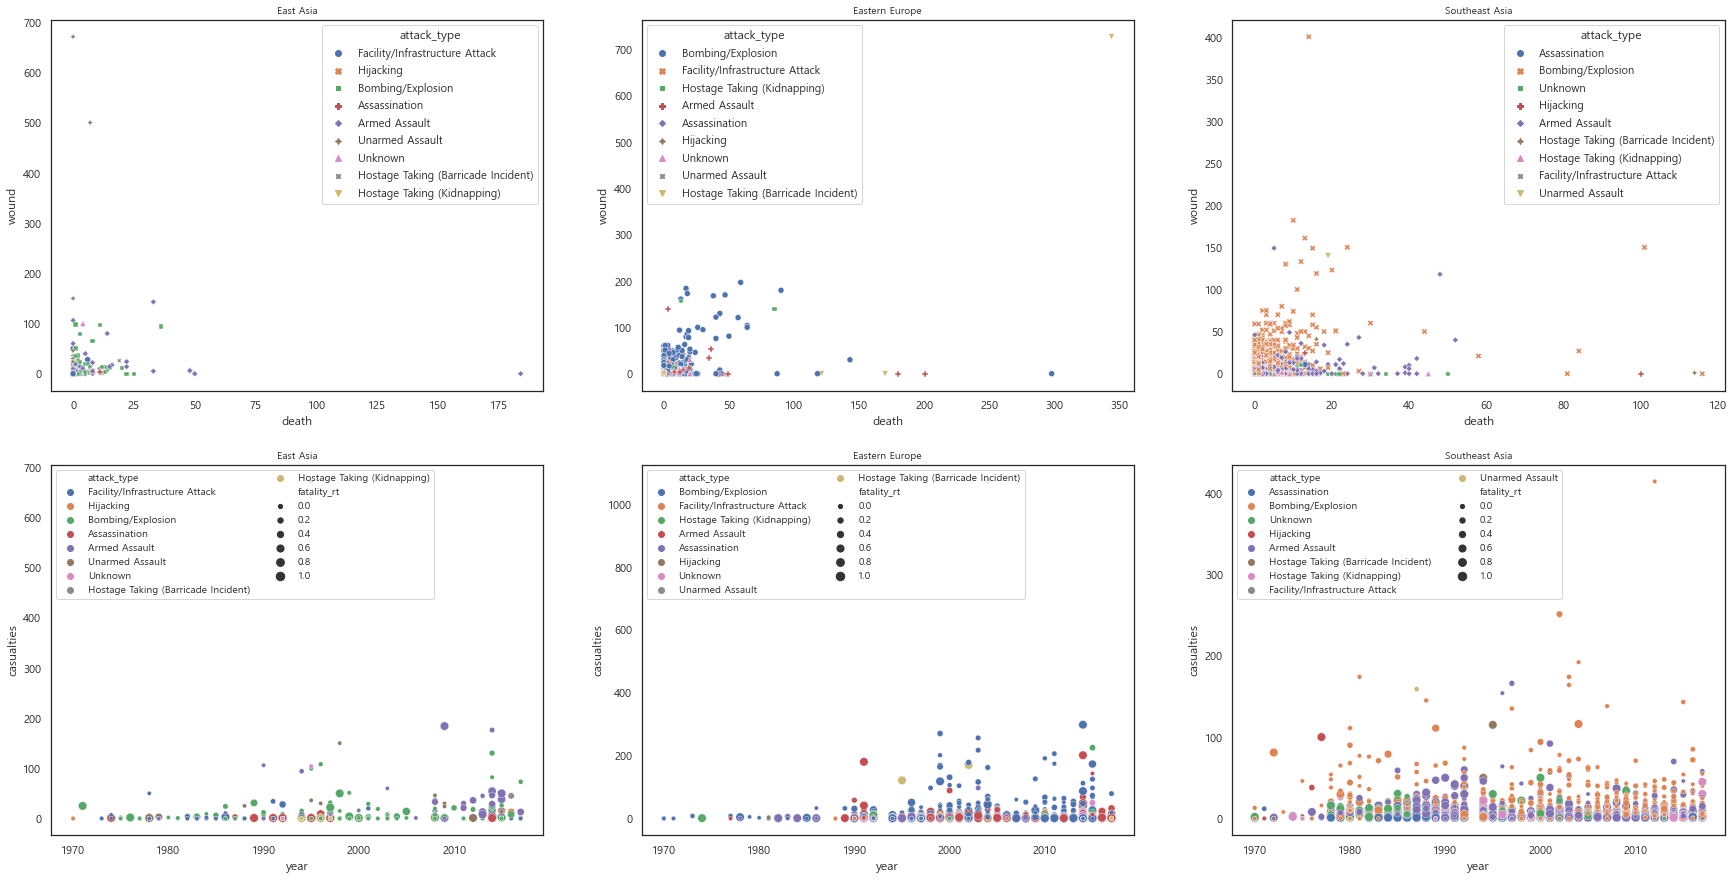

In [47]:
fig, ax = plt.subplots(2,3, figsize=(30,15))

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=removed_outliers[removed_outliers['region']=='East Asia'], ax=ax[0][0])
ax[0][0].set_title("East Asia", fontsize=10)

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='Eastern Europe'], ax=ax[0][1])
ax[0][1].set_title("Eastern Europe", fontsize=10)

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='Southeast Asia'], ax=ax[0][2])
ax[0][2].set_title("Southeast Asia", fontsize=10)


sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=removed_outliers[removed_outliers['region']=='East Asia'], ax=ax[1][0])
ax[1][0].set_title("East Asia", fontsize=10)
ax[1][0].legend(loc="upper left", ncol=2, fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='Eastern Europe'], ax=ax[1][1])
ax[1][1].set_title("Eastern Europe", fontsize=10)
ax[1][1].legend(loc="upper left", ncol=2, fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='Southeast Asia'], ax=ax[1][2])
ax[1][2].set_title("Southeast Asia", fontsize=10)
ax[1][2].legend(loc="upper left", ncol=2, fontsize=10)

plt.show()

**동아시아 지역** - (1995 도쿄 지하철 테러 제외시킴)
- 테러 발생 수 자체가 다른 지역에 비해 낮아 보인다
- 다만 위에서 보았듯이 비무장 공격으로 인한 부상자 수가 1995 도쿄 지하철 테러를 제외 하고도 높게 보이는 사건이 더 있다. 
- 비무장 공격의 종류 중 하나로 화학 공격이 있으며, 특히 타겟이 대중교통이었던 것을 감안하고 높은 부상자 수를 추측해본다.
- 또한 한 건의 무장 공격으로 사망자가 동아시아 평균에 비해 현저히 높게 보인다.
- 다른 지역과 마찬가지로, 폭발물로 인한 테러가 제일 빈번해 보이고, 2000년대 후반에서 2010년대에는 무장 공격의 테러 수가 늘어난 듯 보인다. 

**동유럽 지역**
- 1990년대 후반부터 2010년대까지, 폭발물 형태의 테러 공격이 가장 많이 일어났고 사상자도 많은 것으로 보인다
- 반면에 1990년 초반에는 무장 공격으로 인한 사상자와 사망율이 높았던 것으로 보인다.

**동남아시아 지역**
- 전체적인 패턴으로는 타지역에 비해 테러 건수가 80년대부터 2010년대까지 고루 많아 보이고, 사상자 또한 높게 집계되는 듯이 보인다.
- 폭발물로 인한 테러가 가장 많아 보이며, 그러한 형태의 테러로 부상자가 사망자보다 많다. 다만 몇몇의 예외 사건들 또한 보인다.

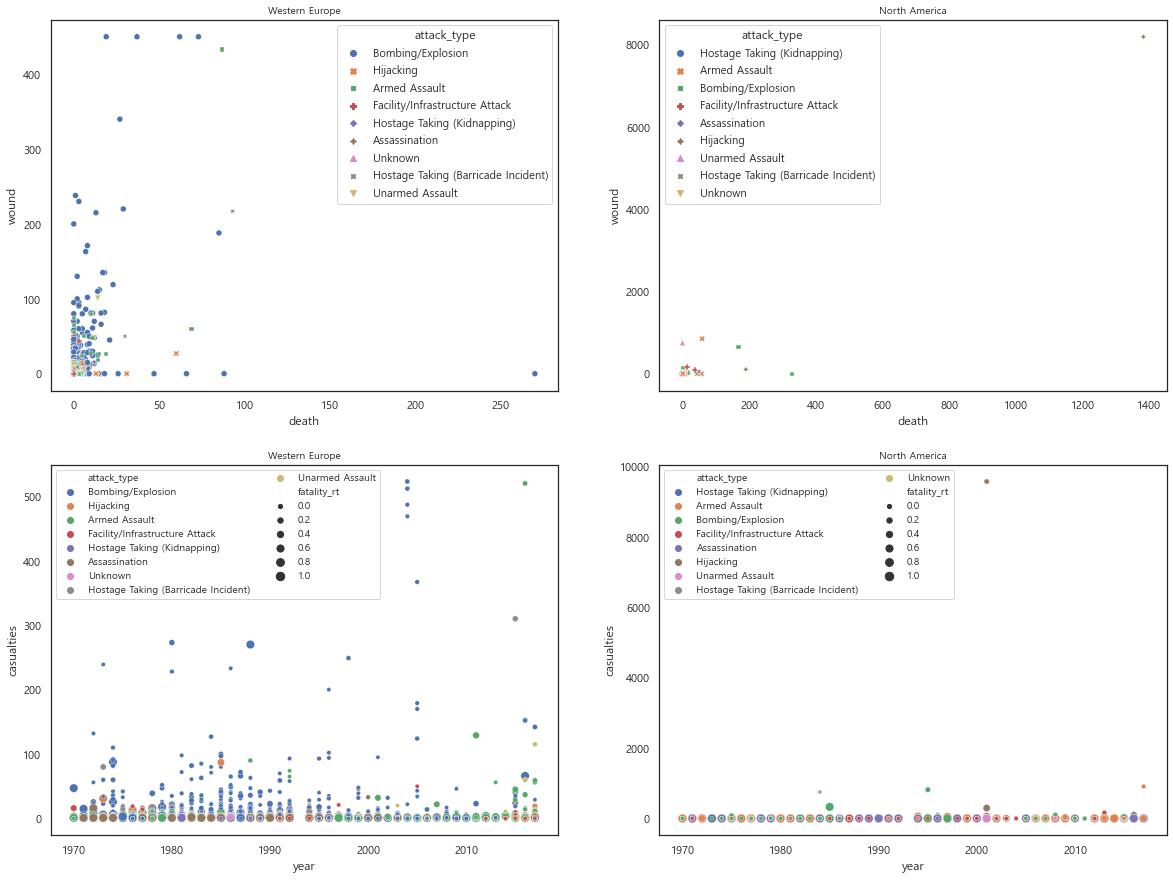

In [48]:
fig, ax = plt.subplots(2,2, figsize=(20,15))

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='Western Europe'], ax=ax[0][0])
ax[0][0].set_title("Western Europe", fontsize=10)

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=terror_success[terror_success['region']=='North America'], ax=ax[0][1])
ax[0][1].set_title("North America", fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='Western Europe'], ax=ax[1][0])
ax[1][0].set_title("Western Europe", fontsize=10)
ax[1][0].legend(loc="upper left", ncol=2, fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=terror_success[terror_success['region']=='North America'], ax=ax[1][1])
ax[1][1].set_title("North America", fontsize=10)
ax[1][1].legend(loc="upper left", ncol=2, fontsize=10)

plt.show()

**서유럽 지역**
- 폭발물로 인한 테러가 가장 많았고, 사상자 또한 가장 높았다. 다른 지역과 마찬가지로, 폭발물로 인한 테러는 사망자보다는 부상자의 수가 더 높게 집계된다.
- 전체적으로 모든 테러 공격 형태에서 타 지역에 비해 비교적 낮은 사상자율을 보여주고 있다.
- 1990년대 중반을 기점으로 후반부에 무력 공격이 증가한 추세로 보인다. 또한 전반부에 비해 후반부에 테러의 수도 줄어든 듯 보인다.
- 또한 후반부에, 특히 2010년대부터 시설물을 타겟으로한 공격이 증가한 추세가 보인다.

**북아메리카 지역**
- 가장 먼저 보이는 outlier로는 위의 히트맵에서 봤듯이 9/11 테러로 사건이다. 북아메리카의 경우 911 사건으로 그래프의 많은 부분이 비교가 불가능해 보이므로 911 사건을 제외시키고 다시 스캐터플롯을 그려본다.

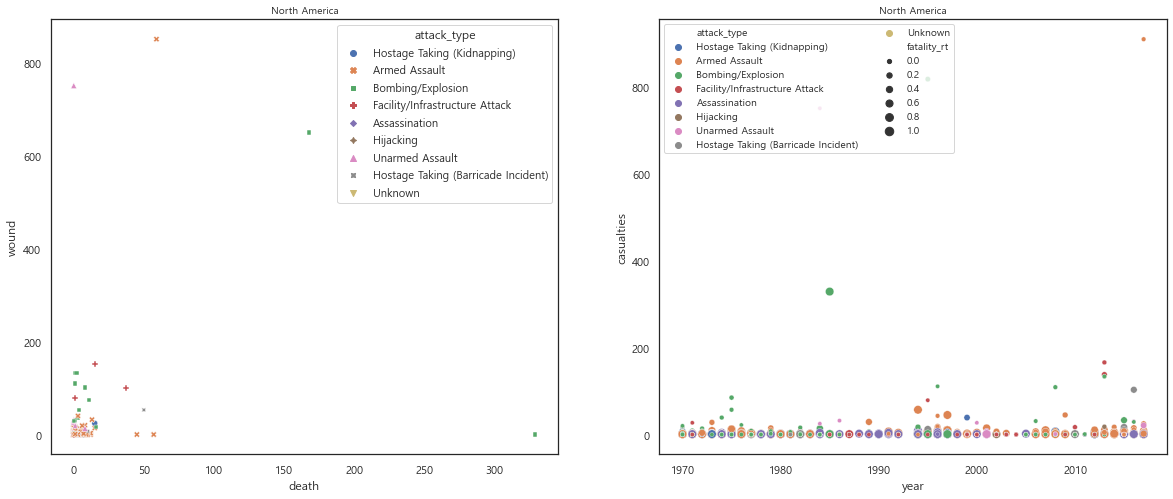

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

sns.scatterplot(x="death", y='wound', hue='attack_type', style='attack_type', data=removed_911[removed_911['region']=='North America'], ax=ax[0])
ax[0].set_title("North America", fontsize=10)

sns.scatterplot(x="year", y='casualties', hue='attack_type', size='fatality_rt', data=removed_911[removed_911['region']=='North America'], ax=ax[1])
ax[1].set_title("North America", fontsize=10)
ax[1].legend(loc="upper left", ncol=2, fontsize=10)

plt.show()

**북아메리카 지역** (911 제외)
- 타 지역에 비해 테러 수가 적은 편이고, 사상자율도 낮은 편이다.
- 시설물 공격이 빈도수가 북아메리카 지역에서는 폭발물 다음으로 많은 공격 형태였지만 사상자율도 낮고 사망자율도 낮기에 위의 두 스캐터 플롯에서는 특별히 부각되지 않는다
- 다만 몇 몇의 무력 공격과 폭발물 공격으로 인한 높은 사상자가 나오기도 했다.
- 특히 1980년대 중분에 있었던 폭발물 사건으로 911 제외하고 가장 높은 사망자가 나오기도 했다.

---

## 7. 2010년대 지역별 테러 양상 분석 <a class="anchor" id="chapter7"></a>

In [50]:
select_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [51]:
period_df = terror_raw[terror_raw['region'].isin(select_regions)]
period_df = terror_raw[terror_raw['year'].isin(select_years)]

In [52]:
period_region = period_df.groupby(['region', 'year'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/4117589635.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



### 7.1. 지역 & 연도별 테러 건수 분석 <a class="anchor" id="chapter_7_1"></a>

In [53]:
fig = px.line(
    period_region, x='year', y='count', color='region', markers=True,
    title = '지역 & 연도별 테러 (2010년대)',
    width=1300, height = 600,
    labels={'region':'지역', 'year':'연도', 'count':'테러 발생 수'},
    template="plotly_white"
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.show()

- 위에서도 봐 왔듯이, 가장 큰 상승률을 중동 지역, 그 다음으로 남아시아 지역이다.
- 시대적 배경으로, 이라크 전쟁 후 미군이 이라크에서 철수 하면서 이슬람 세력간 전쟁이 일어나고, 시리아와 이라크가 가장 큰 격전지가 되었다. 이 시기에 ISIS 테러 집단이 세계에 알려지게 되며, 이슬람 세력 중에서도 가장 악명높게 활동하였다. 
- 비슷한 시기에 미국의 지원을 받으며 탈레반과의 전쟁을 치르던 아프가니스탄이 있었기에 남아시아 지역의 테러 발생 수가 증가하는 현상을 보여준다.

중동지역과 남아시아 지역만 더 집중적으로 분석하여 본다.

### 7.2. 중동 & 북아프리카 지역 테러 분석 (2010년대) <a class="anchor" id="chapter_7_2"></a>

먼저 중동 & 북아프리카 지역의 테러 양상부터 살펴본다.

앞서서 2010년대에 테러의 절대적인 발생 수가 증가함을 확인 하였기에, 이 후의 분석은 직접적인 피해가 가해진 테러만 고려하도록 한다 (i.e, success = 1)

In [54]:
me_raw = period_df[(period_df['success']==1) & (period_df['region']=='Middle East & North Africa')]
me_group = me_raw.groupby(['year', 'country', 'attack_type', 'victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/3765614112.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [55]:
me_group_top10 = me_raw.groupby(['group'])['casualties'].sum().reset_index()
me_group_top10= me_group_top10.sort_values('casualties', ascending=False)[:10]

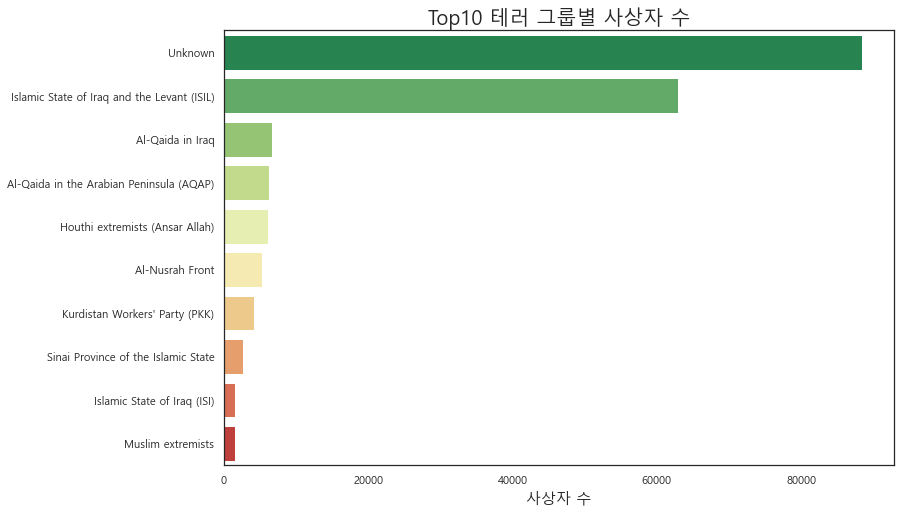

In [56]:
plt.subplots(figsize=(12,8))
sns.barplot(x='casualties', y='group', data=me_group_top10, palette='RdYlGn_r')
plt.title('Top10 테러 그룹별 사상자 수', fontsize=20)
plt.ylabel("")
plt.xlabel('사상자 수', fontsize=15)
plt.show()

In [57]:
me_victim = me_raw.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2143167497.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [58]:
fig = px.scatter(me_victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '중동 & 남아프리카 지역 2010년대 테러 피해자',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white")

fig.show()

- 중동 & 남아프리카 2010년대 테러 피해자를 조사해 보면, 민간인 피해자가 압도적으로 많기도 하고, 가장 많이 타겟 되기도 하였다.
- 또한, 그래프에서 보여지는 맨위 오른쪽만이 민간인으로 분류 하기는 어렵다고 본다. 다른 분류에도, 예를 들어 Transportation/Utilities/Journalists/Airports/Educational Institutions, 등등도 피해자중 민간인의 비율이 높을 것으로 예상된다. 그러므로 총 민간인 피해자 수는 그래프에서 보여지는 수보다 더 많을 것으로 예상된다.
- 즉 2010년대에 이슬람 세력 전쟁으로, 약 8만명 이상의 민간인이 피해를 입었을 것으로 예상되고, 약 3만명 이상의 민간인이 사망하였을 것으로 추측된다. 

### 7.3. 남아시아 지역 테러 분석 (2010년대) <a class="anchor" id="chapter_7_3"></a>

In [59]:
sa_raw = period_df[(period_df['success']==1) & (period_df['region']=='South Asia')]

sa_group_top10 = sa_raw.groupby(['group'])['casualties'].sum().reset_index()
sa_group_top10= sa_group_top10.sort_values('casualties', ascending=False)[:10]

sa_countries = sa_raw.groupby(['year','country'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

sa_victim = sa_raw.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2664447606.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2664447606.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [60]:
fig = px.line(
    sa_countries, x='year', y='casualties', color='country', markers=True,
    title = '국가 & 연도별 테러 (2010년대)',
    width=1300, height = 600,
    labels={'country':'국가', 'year':'연도', 'casualties':'사상자 수'},
    template="plotly_white"
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.show()

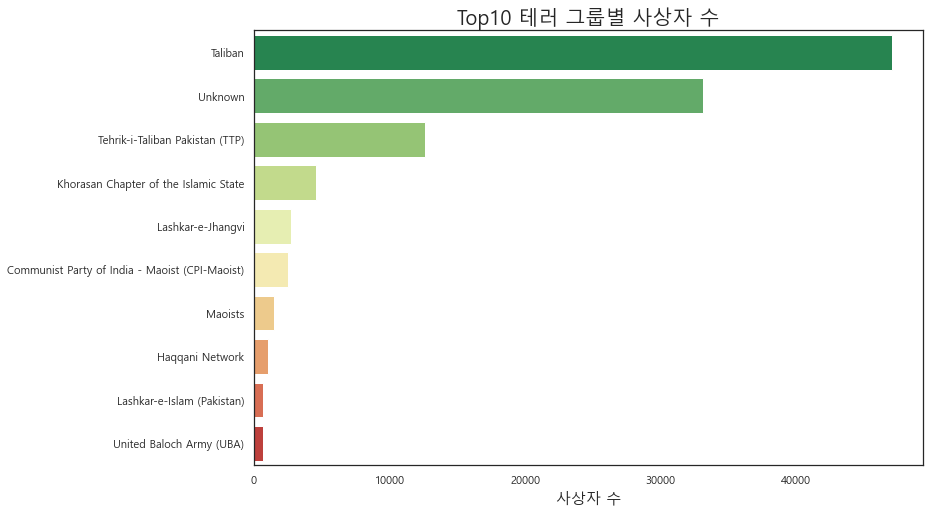

In [61]:
plt.subplots(figsize=(12,8))

sns.barplot(x='casualties', y='group', data=sa_group_top10, palette='RdYlGn_r')
plt.title('Top10 테러 그룹별 사상자 수', fontsize=20)
plt.ylabel("")
plt.xlabel('사상자 수', fontsize=15)

plt.show()

In [62]:
sa_victim = sa_raw.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

fig = px.scatter(sa_victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '남아시아 지역 2010년대 테러 피해자',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white")

fig.show()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/3818301960.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



- 남아시아 지역에서는 민간인보다 더 많은 수의 경찰이 테러의 피해를 입었다. 사망자 수 또한 민간인보다 높은 수로 집계된다.
- 아프가니스탄에서 텔레반 테러 조직과 정부의 대립으로, 파키스탄에서는 지하디스트와 정부의 대립으로 중동지역에 비해 더 많은 경찰의 사상자 수가 집계된 것으로 보인다.
- 또한 중동 지역에서 주로 활동하던 ISIS와 al Queda의 주요 타깃이 민간인이었기에 중동지역에서 더 높은 민간인 사상자 수가 나온 것으로 보인다.

### 7.4. 동남아시아 지역 테러 분석 (2010년대) <a class="anchor" id="chapter_7_4"></a>

In [63]:
sea_raw = period_df[(period_df['success']==1) & (period_df['region']=='Southeast Asia')]

sea_group_top10 = sea_raw.groupby(['group'])['casualties'].sum().reset_index()
sea_group_top10= sea_group_top10.sort_values('casualties', ascending=False)[:10]

sea_countries = sea_raw.groupby(['year','country'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

sea_victim = sea_raw.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/1406075481.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/1406075481.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [64]:
fig = px.line(
    sea_countries, x='year', y='casualties', color='country', markers=True,
    title = '국가 & 연도별 테러 (2010년대)',
    width=1300, height = 600,
    labels={'country':'국가', 'year':'연도', 'casualties':'사상자 수'},
    template="plotly_white",
    hover_data = ['count']
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.show()

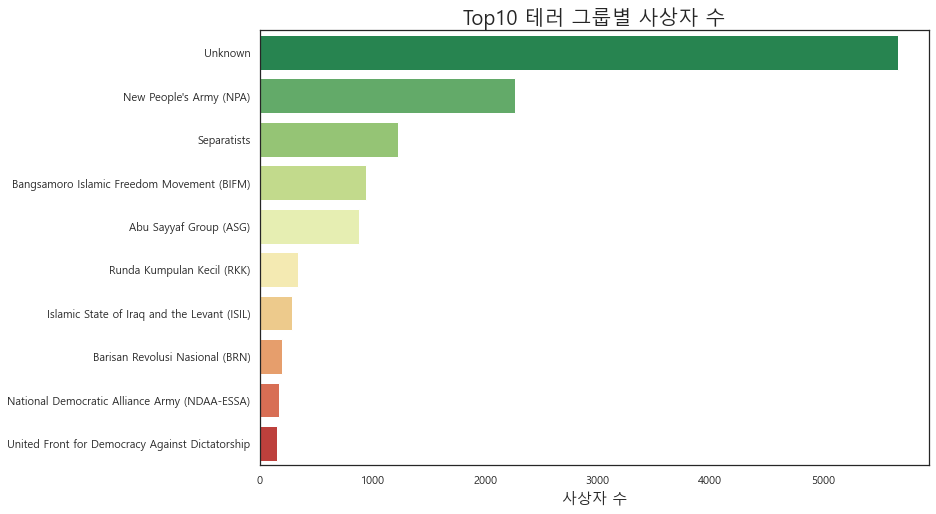

In [65]:
plt.subplots(figsize=(12,8))

sns.barplot(x='casualties', y='group', data=sea_group_top10, palette='RdYlGn_r')
plt.title('Top10 테러 그룹별 사상자 수', fontsize=20)
plt.ylabel("")
plt.xlabel('사상자 수', fontsize=15)

plt.show()

In [66]:
sea_victim = sea_raw.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

fig = px.scatter(sea_victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '동남아시아 지역 2010년대 테러 피해자',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white")

fig.show()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/3548781650.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



- 동남아시아 지역에서는, 앞에서 얘기한 남아시아 지역과 중동 지역에 비해 테러 피해자 수도 절대적으로 적지만, 군인이 대부분으로 보인다.

### 7.5. 나머지 지역 테러 분석 (2010년대) <a class="anchor" id="chapter_7_5"></a>

In [67]:
select_regions

['Middle East & North Africa',
 'South Asia',
 'South America',
 'Western Europe',
 'Southeast Asia',
 'Eastern Europe',
 'North America',
 'East Asia']

In [68]:
regions_remain = ['South America', 'Western Europe', 'Eastern Europe', 'North America', 'East Asia']

In [69]:
remain_raw = period_df[(period_df['success']==1) & (period_df['region'].isin(regions_remain))]

remain_group_top10 = sea_raw.groupby(['group'])['casualties'].sum().reset_index()
remain_group_top10= remain_group_top10.sort_values('casualties', ascending=False)[:10]

remain_countries = remain_raw.groupby(['year','region'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

remain_victim = remain_raw.groupby(['victim', 'region'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2760606111.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/2760606111.py:8: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [70]:
fig = px.line(
    remain_countries, x='year', y='casualties', color='region', markers=True,
    title = '나머지 지역 & 연도별 테러 (2010년대)',
    width=1300, height = 600,
    labels={'region':'지역', 'year':'연도', 'casualties':'사상자 수'},
    template="plotly_white",
    hover_data = ['count']
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.show()

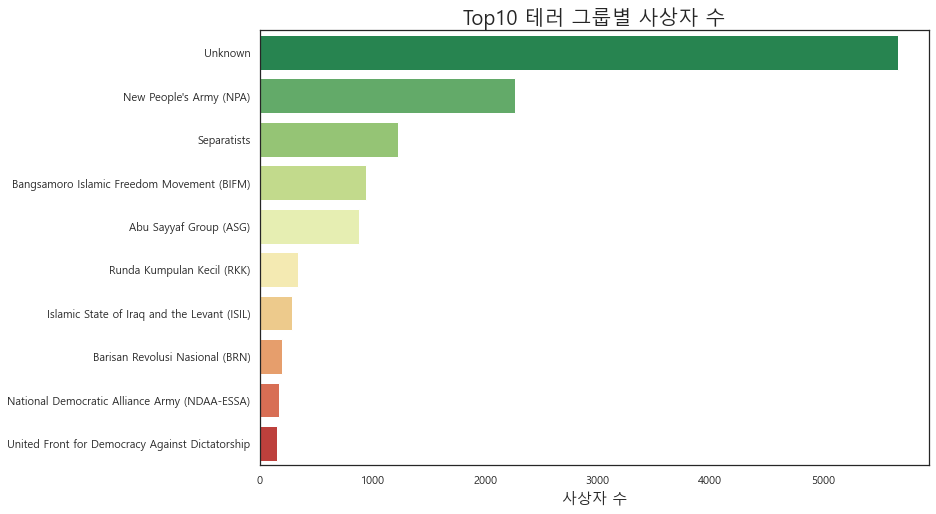

In [71]:
plt.subplots(figsize=(12,8))

sns.barplot(x='casualties', y='group', data=remain_group_top10, palette='RdYlGn_r')
plt.title('Top10 테러 그룹별 사상자 수', fontsize=20)
plt.ylabel("")
plt.xlabel('사상자 수', fontsize=15)

plt.show()

In [72]:
fig = px.scatter(remain_victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '동남아시아 지역 2010년대 테러 피해자',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white",
    hover_data=['region'])

fig.show()

- 주요 특성으로는 동유럽 지역의 2014/2015년도의 테러 증가다. 2014년 2월 20일 러시아 - 우크라이나 전쟁을 시작으로 동유럽 지역의 테러 사상자가 증가한 것이다.
- 또한 시대적 배경과 맞게, 전쟁으로 인한 사상자 수로는 동유럽 지역의 군인이 가장 많게 집계되었다.
- 서유럽 지역에서는 민간인 피해가 가장 많은 것으로 보이며, 다음으로는 business 집단이 높게 나온다. 서유럽 지역의 주요 테러 공격 방식으로 폭탄물 다음으로 시설물 공격이 많았으므로, 그에 따른 business 집단의 피해 상승으로 보인다.

---

## 8. 대한민국 테러 분석 <a class="anchor" id="chapter8"></a>

In [74]:
kr_raw = terror_raw[terror_raw['country']=='South Korea']
kr_success = kr_raw[kr_raw['success']==1]

In [75]:
kr_group_top10 = kr_raw.groupby(['group'])['casualties'].sum().reset_index()
kr_group_top10= kr_group_top10.sort_values('casualties', ascending=False)[:10]

kr_count = kr_success.groupby(['year'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

kr_victim = kr_success.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/3304960302.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/3304960302.py:6: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [76]:
fig = px.line(
    kr_count, x='year', y='count', markers=True,
    title = '대한민국 연도별 테러',
    width=1300, height = 600,
    labels={'year':'연도', 'casualties':'사상자 수'},
    template="plotly_white",
    hover_data = ['casualties'],
)

fig.update_layout(legend = dict(y=1, yanchor="top", x=0.05, xanchor="left"))

fig.show()

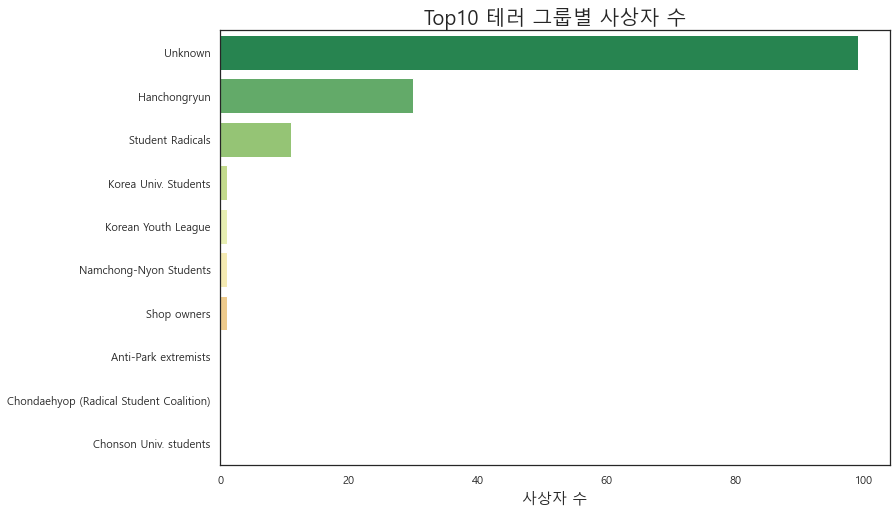

In [77]:
plt.subplots(figsize=(12,8))

sns.barplot(x='casualties', y='group', data=kr_group_top10, palette='RdYlGn_r')
plt.title('Top10 테러 그룹별 사상자 수', fontsize=20)
plt.ylabel("")
plt.xlabel('사상자 수', fontsize=15)

plt.show()

In [78]:
fig = px.scatter(kr_victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '대한민국 테러 피해자',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white")

fig.show()

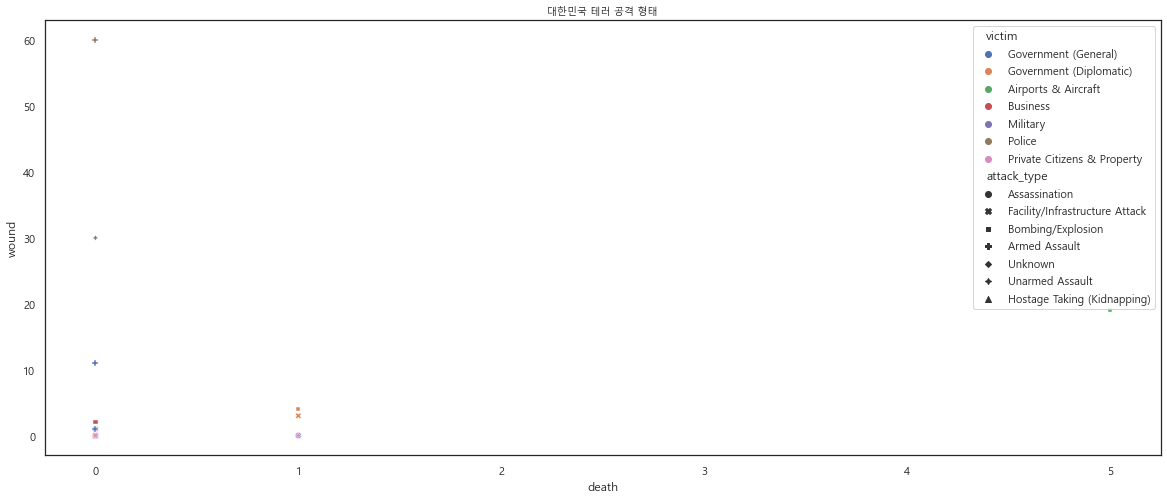

In [79]:
fig, ax = plt.subplots(figsize=(20,8))

sns.scatterplot(x="death", y='wound', hue = 'victim', style='attack_type', data=kr_success)
plt.title("대한민국 테러 공격 형태", fontsize=10)

plt.show()

- 한국은 국외의 테러 압박이나, 종교적 이유로서 테러등이 전혀 없어보이고, 테러 수 자체또한 현저히 적으며 이정도면 테러free 국가라고 볼 수 있지 않나 싶다.
- 1980년대에 그나마 테러의 수가 잡히고, 광주 항쟁으로 인한 사건으로 보인다.
- 그 외에 가장 많은 사상자를 낸 사건으로는 2003년 부안 핵반대 시위로 보인다.
- 우리 나라의 민족 특성인지 모르겠지만, 시위는 많이 하지만 안전하게, 피해없이 하는 듯 싶다.
- 2000년대부터 대통령 탄핵, 탄핵 반대 등등의 많은 정치적 이슈도 있었지만 대부분 촛불집회 등의 평화적인 방식의 시위가 이렇게 테러에서 안전한 국가로 만들지 않았나 싶다.

---

## 9. 테러 타겟 분석 <a class="anchor" id="chapter9"></a>

- 앞서서 지역별 분석 섹션에서 테러 타겟에 대한 분석을 간략하게 해 보았다.
- 더 나아가 지역별 분석이 아닌 전 세계적으로 테러라는 사건으로 인한 민간인 피해자가 얼마나 되는지 알아 보려 한다.

In [80]:
victim = terror_success.groupby(['victim'])['count', 'wound', 'death', 'casualties'].sum().reset_index()

C:\Users\hsada\AppData\Local\Temp/ipykernel_13932/1293497046.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [81]:
fig = px.scatter(victim, x='count', y='casualties', color='victim', size='death', width=1300, height = 600, 
    title = '테러 피해자 분석',
    labels={'victim':'피해자', 'count':'테러 발생 수', 'casualties':'사상자 수'},
    template="plotly_white",
    hover_data=['wound'])

fig.show()

- 1970-2017년 데이터를 통합하여 보았을 때, 테러로 인한 민간인의 피해자가 군인에 비해 2배 정도가 되고, 타겟 당하는 횟수 또한 군인에 비해 현저히 높다.

In [82]:
group = terror_success.groupby(['group'])['count'].sum().reset_index()
group = group.sort_values('count', ascending=False)[1:11]['group'].to_list()
group

['Taliban',
 'Islamic State of Iraq and the Levant (ISIL)',
 'Shining Path (SL)',
 'Al-Shabaab',
 'Farabundo Marti National Liberation Front (FMLN)',
 'Irish Republican Army (IRA)',
 'Boko Haram',
 "New People's Army (NPA)",
 'Revolutionary Armed Forces of Colombia (FARC)',
 "Kurdistan Workers' Party (PKK)"]

In [83]:
top10 = terror_success[terror_success['group'].isin(group)]
top10_total = top10.groupby(['group'])['casualties'].sum().reset_index()

In [84]:
top10_citizens = top10.groupby(['group', 'victim'])['casualties'].sum().reset_index()
top10_citizens = top10_citizens[top10_citizens['victim']=='Private Citizens & Property']

In [85]:
top10_citizens = top10_citizens.reset_index(drop=True)

In [86]:
top10_victims = top10_total.copy()
top10_victims['citizens'] = top10_citizens['casualties']

In [87]:
top10_victims = top10_victims.sort_values('casualties', ascending=False)

In [88]:
top10_victims_tidy = top10_victims.melt(id_vars='group').rename(columns=str.title)

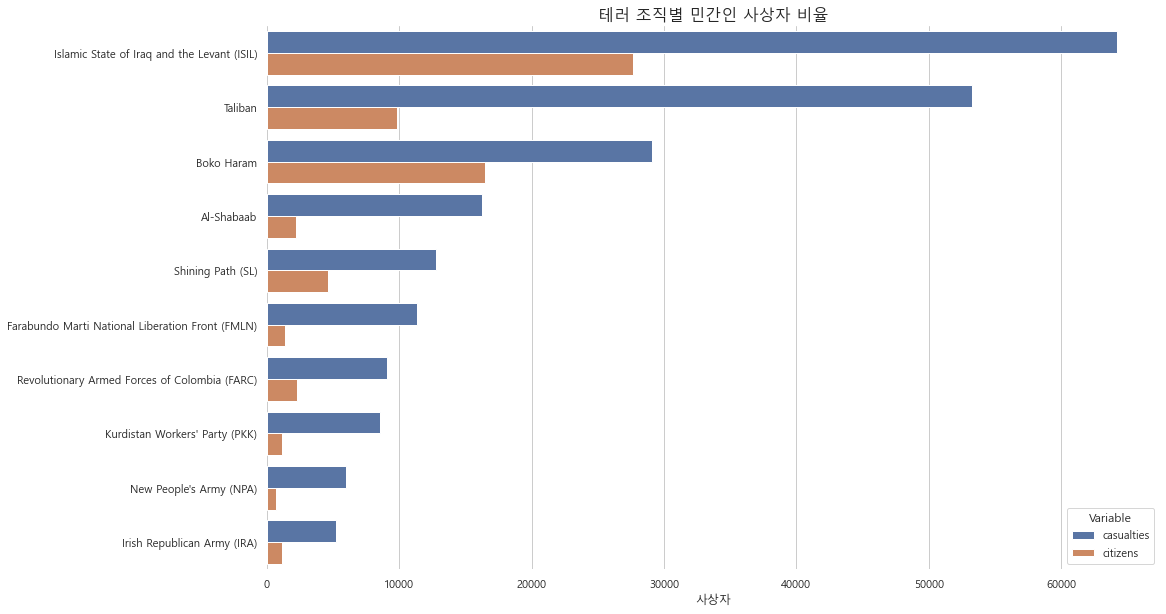

In [89]:
plt.figure(figsize=(16,10))

sns.set_color_codes("pastel")
plots = sns.barplot(data = top10_victims_tidy, x='Value', y='Group', hue='Variable')
plt.title('테러 조직별 민간인 사상자 비율', fontsize=16)
plt.xlabel('사상자', fontsize=12)
plt.ylabel("")
plt.grid(axis='x')
sns.despine(left=True, bottom=True)
plt.show()

- 세계적으로 사상자를 가장 많이 낸 Top10 테러 세력만 비교하여 본다. 각 세력마다 전체 사상자수와 민간인 사상자 수를 비교하여 본다
- ISIS의 경우 절대적으로 가장 많은 사상자를 냈고, 민간인 또한 가장 많이 포함되었다.

---

## 10. Conclusion <a class="anchor" id="chapter10"></a>

- 다만, 데이터의 수집 방법상 테러로 인한 직접적인 피해자 수만 집계 됐을 가능성이 크다.
- 그러므로 간접적인 사망자 혹은 부상자는 현 데이터 분석에 포함 되지 않았다. 간접적인 요소로는 가난, 시설물 파괴 등으로인한 죽음 혹은 정신적 피해, 그리고 질병이 있을 수 있다.
- 또한, 데이터 배포 기관인 START에서 명시 하였듯이, 2012년 이후로 데이터 수집 방식이 바뀌어 더 많은 정보를 집계 하였다 한다.
- 즉, 그 말은 2012 이전의 테러 범죄는 상당 부분이 누락 되었을 가능성이 있다는 뜻이다


**- 우리가 분석으로 보지 못한 수많은 테러의 피해자가 더 있었을 것이다.**

In [90]:
topic="war children"
numResults=1000
url ="https://www.google.com/search?q="+topic+"&tbm=nws&hl=en&num="+str(numResults)

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

results = soup.find_all('div', attrs = {'class': 'ZINbbc'})
descriptions = []
for result in results:
    try:
        description = result.find('div', attrs={'class':'s3v9rd'}).get_text()
        if description != '': 
            descriptions.append(description)
    except:
        continue

text = ''.join(descriptions)
sp = spacy.load('en_core_web_sm')
doc = sp(text)

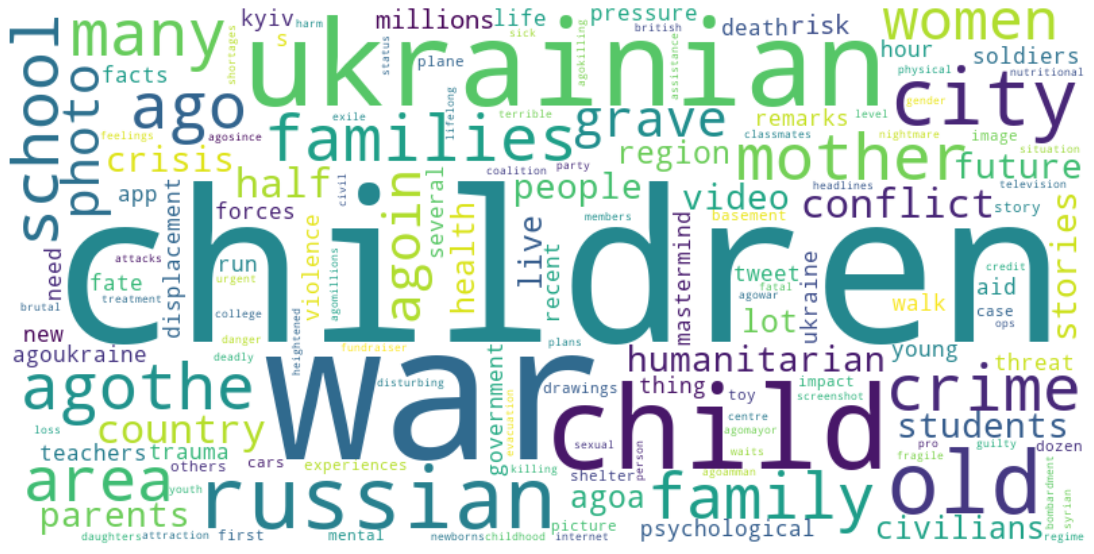

In [91]:
ignore = ['day', 'week', 'year', 'hours', 'days', 'month', 'months', 'weeks']
newText =''
for word in doc:
    if str(word) in ignore:
        continue
    elif word.pos_ in ['ADJ', 'NOUN']:
        newText = " ".join((newText, word.text.lower()))

wordcloud = WordCloud(
    width=800, height=400, 
    stopwords=STOPWORDS, 
    background_color="white",
    max_words=150
    ).generate(newText)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

---

## References <a class="anchor" id="References"></a>

START (National Consortium for the Study of Terrorism and Responses to Terrorism). (2021). *Global Terrorism Database* (GTD) [Data set]. University of Maryland. https://www.start.umd.edu/gtd

START (National Consortium for the Study of Terrorism and Responses to Terrorism). (2021, August). *Global Terrorism Database codebook: Methodology, inclusion criteria, and variables.* University of Maryland. https://www.start.umd.edu/gtd/downloads/Codebook.pdf 

In [92]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))